In [ ]:
library(tidyverse)
library(rdmc)
library(vroom)
library(cowplot)
library(patchwork)
library(ggraph)
library(ape)
library(ggExtra)

tts <- 16
tts_small <- 14
theme_set(theme_classic(tts))

options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
source("../color_df.R")

colz_df <- color_df
color_df <-
    color_df %>% 
    mutate(
        ssp_pop = pop,
        pop = str_remove_all(ssp_pop, "(LR_|Teo_|random1_|random2_)")
    ) %>% 
    dplyr::select(-ssp_pop) %>% 
    distinct()
color_df

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 200)


raisd_sim <- vroom("../data/mushi/RAiSD_Report.v5--LR--random1_Palmar_Chico--msprime", "\t", skip = 1, col_names = c("pos", "mu"))
q <- quantile(raisd_sim$mu, 0.99, na.rm = TRUE)
q
blocks <- vroom("../data/raisd/v5--LR--random1_Palmar_Chico.corrected_block_outliers_merged.txt", delim = "\t", 
                col_names = c("chrom", "start", "end", "mu")) %>% 
                filter(chrom == "chr3", mu > q)



outlier_df_L <- vroom("../data/raisd/RAiSD_Report.v5--LR--random1_Palmar_Chico--chr3--0--238017767.corrected", delim = "\t", col_names = c("chrom", "start", "pos", "end", "var", "sfs", "ld", "mu")) %>%
    filter(mu > 0)



ggplot() +
    geom_point(data = outlier_df_L, mapping = aes(pos, mu)) +
    ylab(expression(mu)) +
    xlim(1.2e7, 1.8e7) +
    ylim(0, 8) +
    xlab("Position")


outlier_df <- vroom("../data/raisd/RAiSD_Report.v5--LR--random1_Palmar_Chico--chr3--0--238017767.corrected", delim = "\t", col_names = c("chrom", "start", "pos", "end", "var", "sfs", "ld", "mu")) %>%
    filter(mu > q)


ggplot() +
    geom_point(data = outlier_df, mapping = aes(pos, mu)) +
    geom_point(data = blocks, mapping = aes((start + end)/2, mu), size = 2, colour = "green") +
    geom_segment(data = blocks, mapping = aes(x = start, xend = end, y = q-1, yend = q-1), lwd = 4, colour = "green") +
    ylab(expression(mu)) +
    xlim(1.2e7, 1.8e7) +
    ylim(0, 8) +
    xlab("Position")
    

In [ ]:
#raisd <- vroom("../data/raisd/RAiSD_Report.v5--LR--random1_Palmar_Chico--chr10--0--152435371.txt", delim = "\t", skip = 1, 
#              col_names = c("pos", "start", "end", "var", "sfs", "ld", "mu")) %>% 
#              mutate(chrom = "chr10")    

raisd <- vroom("../data/raisd/RAiSD_Report.v5--Teo--Amatlan_de_Canas--chr2--0--243675191.txt", delim = "\t", skip = 1,
                 col_names = c("pos", "start", "end", "var", "sfs", "ld", "mu"))

raisd_c <- vroom("../data/raisd/RAiSD_Report.v5--Teo--Amatlan_de_Canas--chr2--0--243675191.corrected", delim = "\t", 
                 col_names = c("chrom", "pos", "start", "end", "var", "sfs", "ld", "mu"))%>% 
                dplyr::select(-start, -end)


raisd_j <- full_join(raisd, raisd_c, by = c("pos"), suffix = c("_raw", "_corrected")) %>% drop_na()


In [ ]:
neutral <- 1
a <- ggplot() + geom_point(data = filter(raisd_j, mu_raw > neutral), mapping = aes(pos, mu_raw))
b <- ggplot() + geom_point(data = filter(raisd_j, mu_corrected > neutral), mapping = aes(pos, mu_corrected), colour = "red")

a + b 

In [ ]:
head(raisd)

In [ ]:
plot(raisd_j$mu_raw, raisd_j$mu_corrected, pch = ".")
cor.test(raisd_j$mu_raw, raisd_j$mu_corrected, method = "pe")

# Sharing

In [ ]:

all_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--RANDOM1_Palmar_Chico", 
    "v5--LR--RANDOM2_Palmar_Chico", 
    "v5--LR--random", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--RANDOM1_Palmar_Chico", 
    "v5--Teo--RANDOM2_Palmar_Chico", 
    "v5--Teo--random", 
    "v5--Teo--San_Lorenzo"
)

pop_pairs <- 
combn(all_pops, 2) %>% 
    t() %>% 
    data.frame() %>% 
    set_colnames(c("pop1", "pop2")) %>% 
    as_tibble() %>% 
    mutate(pop1 = str_replace_all(pop1, "random1", "RANDOM1"),
           pop2 = str_replace_all(pop2, "random2", "RANDOM2"))
head(pop_pairs)


In [ ]:
gen_map_all_chr <- read_delim("../data/map/ogut_v5.map.txt", delim = "\t") %>% 
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>% 
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    cm_bp <- tibble(rr = (df2$cm - df1$cm)/(df2$pos - df1$pos)/100)
    bind_cols(df2, cm_mb, cm_bp)
  }) %>% 
  mutate(chr = paste0("chr", chr))

median(gen_map_all_chr$rr)

get_rr <- function(genetic_df, sweep_chr, sweep_positions){
  chr_df <- filter(genetic_df, chr == sweep_chr)
  median(approx(x = chr_df$pos, y = chr_df$rr, xout = sweep_positions)$y)
}

get_cm <- function(genetic_df, sweep_chr, sweep_start, sweep_end){
  chr_df <- filter(genetic_df, chr == sweep_chr)
  cm_start <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_start)$y
  cm_end <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_end)$y
  cm_end - cm_start
}


share_df <- vroom::vroom("../data/raisd/v5--allpops--shared_outliers.txt", 
             col_names = c("chrom", "start", "end", "size", "populations")) %>% 
    mutate(populations = str_remove_all(populations, "(data/raisd/|.corrected_block_outliers_merged.txt)"),
           populations = str_replace_all(populations, "random1", "RANDOM1"),
           populations = str_replace_all(populations, "random2", "RANDOM2"),
           type = case_when(
               grepl("LR", populations) & grepl("Teo", populations) ~ "both",
               grepl("LR", populations) & !grepl("Teo", populations) ~ "Landraces",
               !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
               TRUE ~ "nan"
    ),
        pop_count = str_count(populations, ",") + 1,
        Landraces_count = str_count(populations, "LR"),
        Teosinte_count =  str_count(populations, "Teo")        
        ) %>% 
    filter(size > 1) %>% 
    rowwise() %>% 
    mutate(cm = get_cm(genetic_df = gen_map_all_chr, sweep_chr = chrom, sweep_start = start, sweep_end = end)) %>% 
    ungroup()

sweep_counts_df <- share_df %>% 
    group_by(type) %>%
    summarise(total_sweeps = n()) %>%
    ungroup() %>% 
    mutate(total_sweeps = ifelse(type == "both", sum(.$total_sweeps), total_sweeps))

head(sweep_counts_df)

head(share_df)


In [ ]:
pops_to_count <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--random1_Palmar_Chico",
    "v5--LR--random",
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--random1_Palmar_Chico", 
    "v5--Teo--random", 
    "v5--Teo--San_Lorenzo"
)

colz_df <- colz_df %>% 
    mutate(
        pop = str_remove_all(pop, "random(1|2)_"),
        pop = str_replace_all(pop, "LR_", "Landrace "),
        pop = str_replace_all(pop, "Teo_", "Teosinte "),
        pop = str_replace_all(pop, "_", " "),
        pop = str_replace_all(pop, "random", "rangewide")
    ) %>% 
    distinct()


population <- str_remove_all(pops_to_count, "random1_") %>% 
            str_replace_all("v5--Teo--", "Teosinte ") %>% 
            str_replace_all("v5--LR--", "Landrace ") %>% 
            str_replace_all("_", " ") %>% 
            str_replace_all("random", "rangewide")


counts <- pops_to_count %>% map_dbl(~{
    vroom::vroom(str_glue("../data/raisd/{.x}.corrected_block_outliers_merged.txt")) %>% 
    nrow()
})

count_df <- tibble(
        population = population,
        counts = counts) %>% 
        left_join(., colz_df, by = c("population" = "pop"))

sweep_pop_count <- 
count_df %>% 
    mutate(ssp = ifelse(grepl("Landrace", population), "Landraces", "Teosinte")) %>% 
    ggplot(aes(counts, population, fill = color)) +
    geom_bar(stat = "identity") +
    ylab("Population") +
    xlab("Sweep frequency") +
    scale_fill_identity() +
    facet_wrap(~ssp, scales = "free_y", ncol = 1) +
    theme(axis.text.y = element_blank())

sweep_pop_count

In [ ]:
## HOW MANY SWEEPS ARE EXLUSIVE TO SAMPLING LOCATIONS?

geos <- c(
    "Amatlan_de_Canas", 
    "Crucero_Lagunitas", 
    "Los_Guajes", 
    "Palmar_Chico", 
    "random", 
    "El_Rodeo",
    "San_Lorenzo"
)

share_df %>% 
 rowwise() %>% 
 mutate(n_geos = sum(str_count(populations, geos))) %>% 
 filter(pop_count == 2, n_geos == 1)

#ZERO!


prop_all,sum(Landraces_count == 5),n()
<dbl>,<int>,<int>
0.02,31,1550


prop_all,sum(Teosinte_count == 6),n()
<dbl>,<int>,<int>
0,0,660


chrom,start,end,size,populations,type,pop_count,Landraces_count,Teosinte_count,cm
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>
chr1,10430149,10517583,87434,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,,v5--LR--RANDOM1_Palmar_Chico,",Landraces,5,5,0,0.180011106
chr1,96235966,96448250,212284,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,,v5--LR--RANDOM1_Palmar_Chico,",Landraces,5,5,0,0.038239022
chr1,126901574,127575919,674345,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,v5--LR--RANDOM1_Palmar_Chico,",Landraces,5,5,0,0.011045036
chr1,270086440,270229990,143550,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,,v5--LR--RANDOM1_Palmar_Chico,",Landraces,5,5,0,0.057500270
chr1,272261071,272472669,211598,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,,v5--LR--RANDOM1_Palmar_Chico,",Landraces,5,5,0,0.164441328
chr10,60338213,60555502,217289,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,,v5--LR--RANDOM1_Palmar_Chico,",Landraces,5,5,0,0.003870363
chr10,80828083,81059822,231739,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,,v5--LR--RANDOM1_Palmar_Chico,",Landraces,5,5,0,0.055426858
chr10,101720141,102094633,374492,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,,v5--LR--RANDOM1_Palmar_Chico,",Landraces,5,5,0,0.041099915
chr10,105872580,106570305,697725,"v5--LR--Amatlan_de_Canas,v5--LR--Crucero_Lagunitas,v5--LR--Los_Guajes,v5--LR--San_Lorenzo,,v5--LR--RANDOM1_Palmar_Chico,",Landraces,5,5,0,0.036720938


`summarise()` has grouped output by 'pop_count'. You can override using the `.groups` argument.



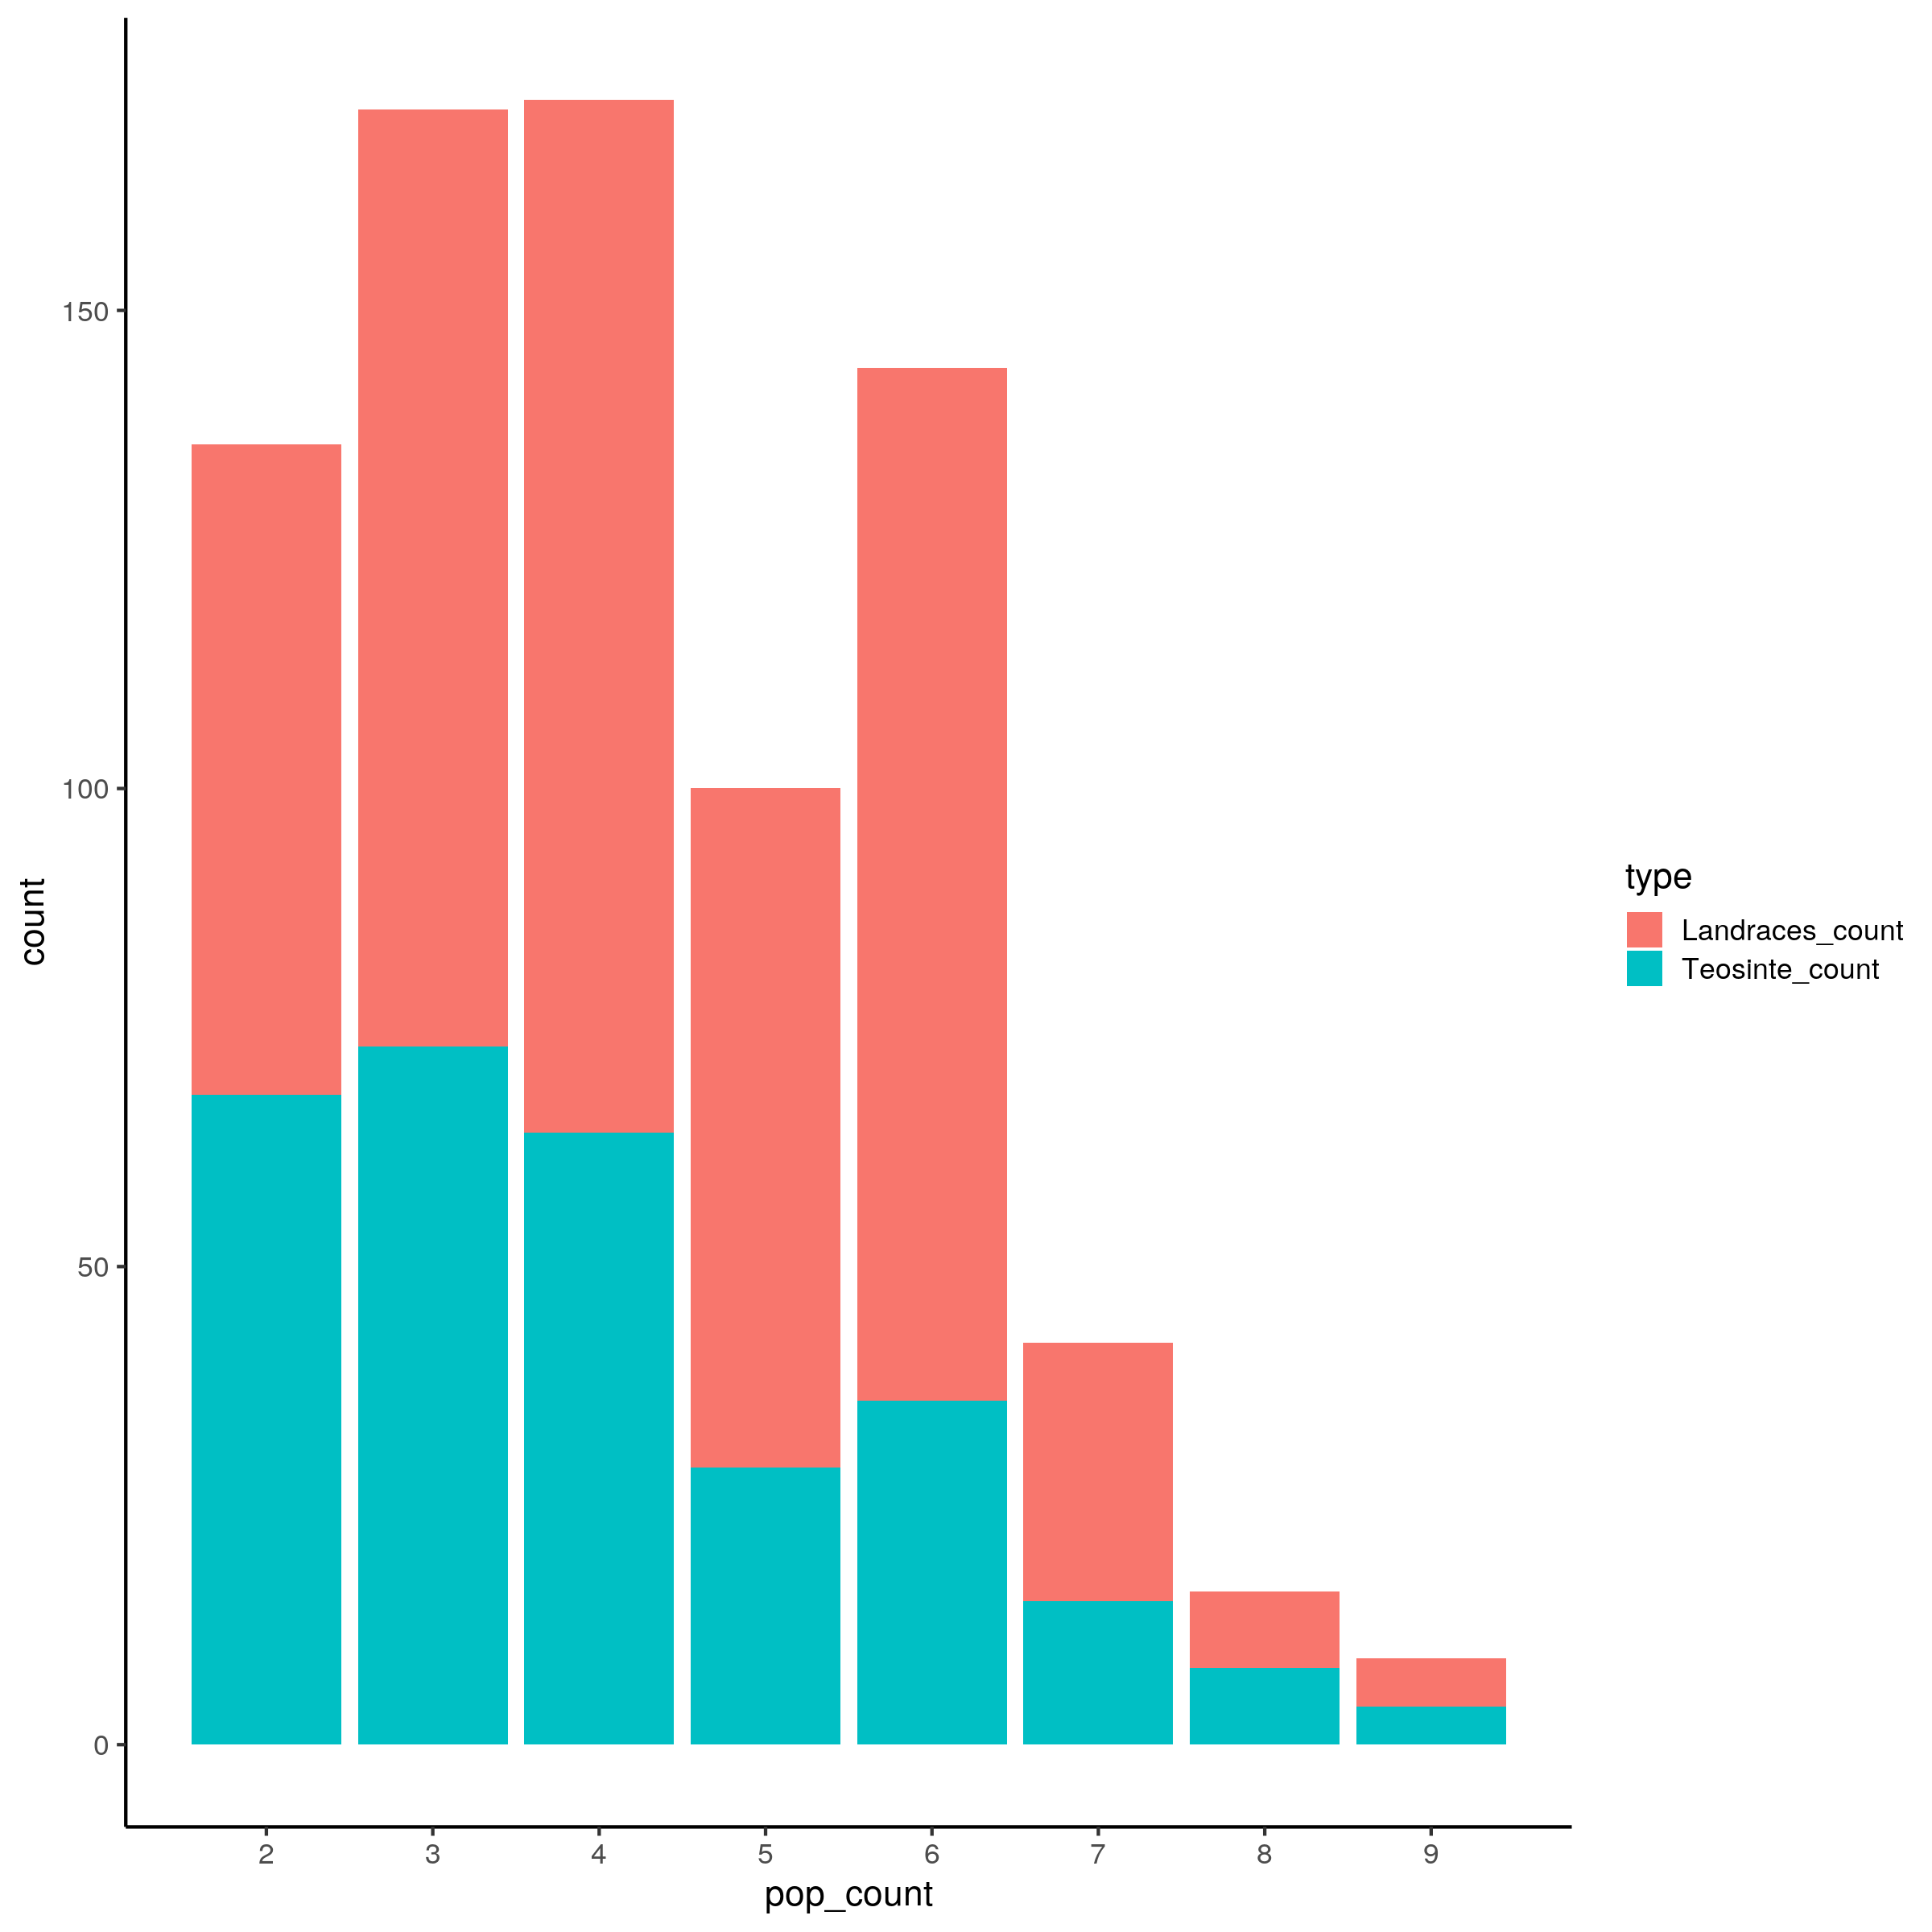

In [113]:
## HOW MANY SWEEPS ARE SHARE BY ALL LR AND ALL TEO?
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 200)


recount_df <- 
share_df %>%
    mutate(
    populations = str_remove_all(populations,  "v5--LR--RANDOM2_Palmar_Chico|v5--LR_Palmar_Chico|v5--Teo_Palmar_Chico"),
    populations = str_remove_all(populations,  "v5--Teo--RANDOM2_Palmar_Chico|v5--Teo--random|v5--LR--random"),
    type = case_when(
               grepl("LR", populations) & grepl("Teo", populations) ~ "both",
               grepl("LR", populations) & !grepl("Teo", populations) ~ "Landraces",
               !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
               TRUE ~ "nan"
    )
) %>% 
    mutate(
        Teosinte_count = str_count(populations, "Teo"),
        Landraces_count = str_count(populations, "LR"),
        pop_count = Teosinte_count + Landraces_count
                                    
    )

recount_df %>%
    filter(type != "both") %>% 
    mutate(Landraces_count = str_count(populations, "LR")) %>% 
    filter(Landraces_count > 0) %>% 
    summarise(prop_all = sum(Landraces_count == 5)/n(), sum(Landraces_count == 5), n())

recount_df %>%
    filter(type != "both") %>% 
    mutate(Teosinte_count = str_count(populations, "Teo")) %>% 
    filter(Teosinte_count > 0) %>% 
    summarise(prop_all = sum(Teosinte_count == 6)/n(), sum(Teosinte_count == 6), n())
    

recount_df %>% 
    filter(type != "both") %>% 
    mutate(Landraces_count = str_count(populations, "LR")) %>% 
    filter(Landraces_count >= 5)

aplot <- recount_df %>% 
filter(type %in% c("both", "Teosinte", "Landraces")) %>% 
ggplot(aes(pop_count, fill = type)) +
geom_histogram(binwidth = 0.5) +
facet_wrap(~type, scales = "free")

bplot <- recount_df %>%
    filter(Teosinte_count > 0 | Landraces_count > 0) %>% 
    ggplot(aes(Teosinte_count, Landraces_count, colour = type)) +
    geom_jitter(width = .25, height = .25, alpha = 0.6) +
    theme(legend.position = "n")

recount_df %>% 
filter(type %in% c("both")) %>% 
dplyr::select(pop_count, Landraces_count, Teosinte_count) %>% 
pivot_longer(cols = -pop_count, names_to = "type", values_to = "count") %>% 
group_by(pop_count, type) %>% 
summarise(count = sum(count)) %>% 
ggplot(aes(pop_count, count, fill = type)) +
geom_bar(stat = "identity") +
scale_x_continuous(n.breaks = 10)





In [ ]:
options(repr.plot.width = 5, repr.plot.height = 6, repr.plot.res = 200)


p_den <- share_df %>% 
    filter(pop_count > 1) %>% 
    ggplot(aes(log10(cm), colour = type)) +
    geom_density() +
    xlab(expression(paste(log[10], " sweep size")))


q_df <- share_df %>% 
    group_by(type) %>% 
    summarise(q25 = log10(quantile(cm, c(0.25), na.rm = T)),
              q50 = log10(quantile(cm, c(0.5), na.rm = T)),
              q75 = log10(quantile(cm, c(0.75), na.rm = T)))

q_df

cmshare_plot <- share_df %>% 
    filter(pop_count > 1) %>% 
    ggplot(aes(log10(cm), pop_count)) +
    geom_point(alpha = 0.2, shape = 1) +
    geom_segment(data = q_df, aes(x = q25, xend = q75, y = 0, yend = 0), lwd = 1.2, colour = "grey50", inherit.aes = T) +
    geom_point(data = q_df, aes(q50, 0), colour = "grey50", inherit.aes = T, size = 3) +
    geom_smooth(se = F, color = "grey10") +
    facet_wrap(~type, ncol = 1, scales = "fixed") +
    xlab(expression(paste(log[10], " sweep size (cM)"))) +
    ylab("Number of populations") +
    scale_y_continuous(breaks = seq(0,12, by = 4)) +
    theme(strip.text.x = element_text(size = tts_small))

cmshare_plot

In [ ]:
all_pops %>% 
    map_df(~{
        shared_sweep <- length(grep(.x,  share_df$populations))
        tibble(populations = .x, shared_sweep)
        })


share_df %>% 
        filter(pop_count  == 1) %>% 
        group_by(populations) %>% 
        summarise(unique_sweep = n())

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)


all_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--RANDOM1_Palmar_Chico", 
    "v5--LR--random", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--RANDOM1_Palmar_Chico", 
    "v5--Teo--random", 
    "v5--Teo--San_Lorenzo"
)


unique_sweep_df <- 
full_join(
    all_pops %>% 
    map_df(~{
        shared_sweep <- length(grep(.x,  share_df$populations))
        tibble(populations = .x, shared_sweep)
        }),
    share_df %>% 
        filter(pop_count  == 1) %>% 
        group_by(populations) %>% 
        summarise(unique_sweep = n())
) %>% 
    mutate(p_unique = unique_sweep/shared_sweep)

range(unique_sweep_df$p_unique, na.rm = T)


pop_order <- arrange(unique_sweep_df, p_unique) %>% pull(populations)

unique_plot_df <- 
unique_sweep_df %>% 
    mutate(
           #populations = factor(populations, level = pop_order),
           pop = populations,
           total = shared_sweep
    ) %>%
    separate(pop, c("ref", "ssp", "pop"), "--")


unique_plot_df %>% 
    group_by(ssp) %>% 
    summarise(mean(p_unique, na.rm = TRUE))

unique_plot <- 
unique_plot_df %>% 
    filter(!grepl("RANDOM2", pop)) %>% 
    mutate(pop = str_remove_all(pop, "RANDOM1_")) %>% 
    left_join(., color_df, by = "pop") %>% 
    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
    ggplot(aes(pop, p_unique, fill = color)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ssp, ncol = 1, scales = "free", labeller = labeller(ssp = c("LR" = "Landraces", "Teo" = "Teosinte"))) +
    geom_hline(yintercept = 0.5, lty = 2) +
    coord_flip() +
    scale_fill_identity() +
    xlab("Population") +
    ylab("Unique sweep\nproportion") +
    theme(axis.text.y=element_blank(),
          strip.text.x = element_text(size = tts_small))


unique_plot
summary(glm(cbind(unique_sweep, total) ~ ssp, data = unique_plot_df, family = binomial))



share_perpop_df <- 
all_pops %>% 
    map_df(~{
        pop_df1 <- filter(share_df, grepl(.x, populations))
        tibble(pop=.x, pop_count = pop_df1$pop_count)
    })

share_perpop_df %>% 
    ggplot(aes(pop_count)) +
    geom_histogram() +
    scale_y_log10() +
    facet_wrap(~pop, scale = "fixed")



`summarise()` has grouped output by 'Landraces_count'. You can override using the `.groups` argument.



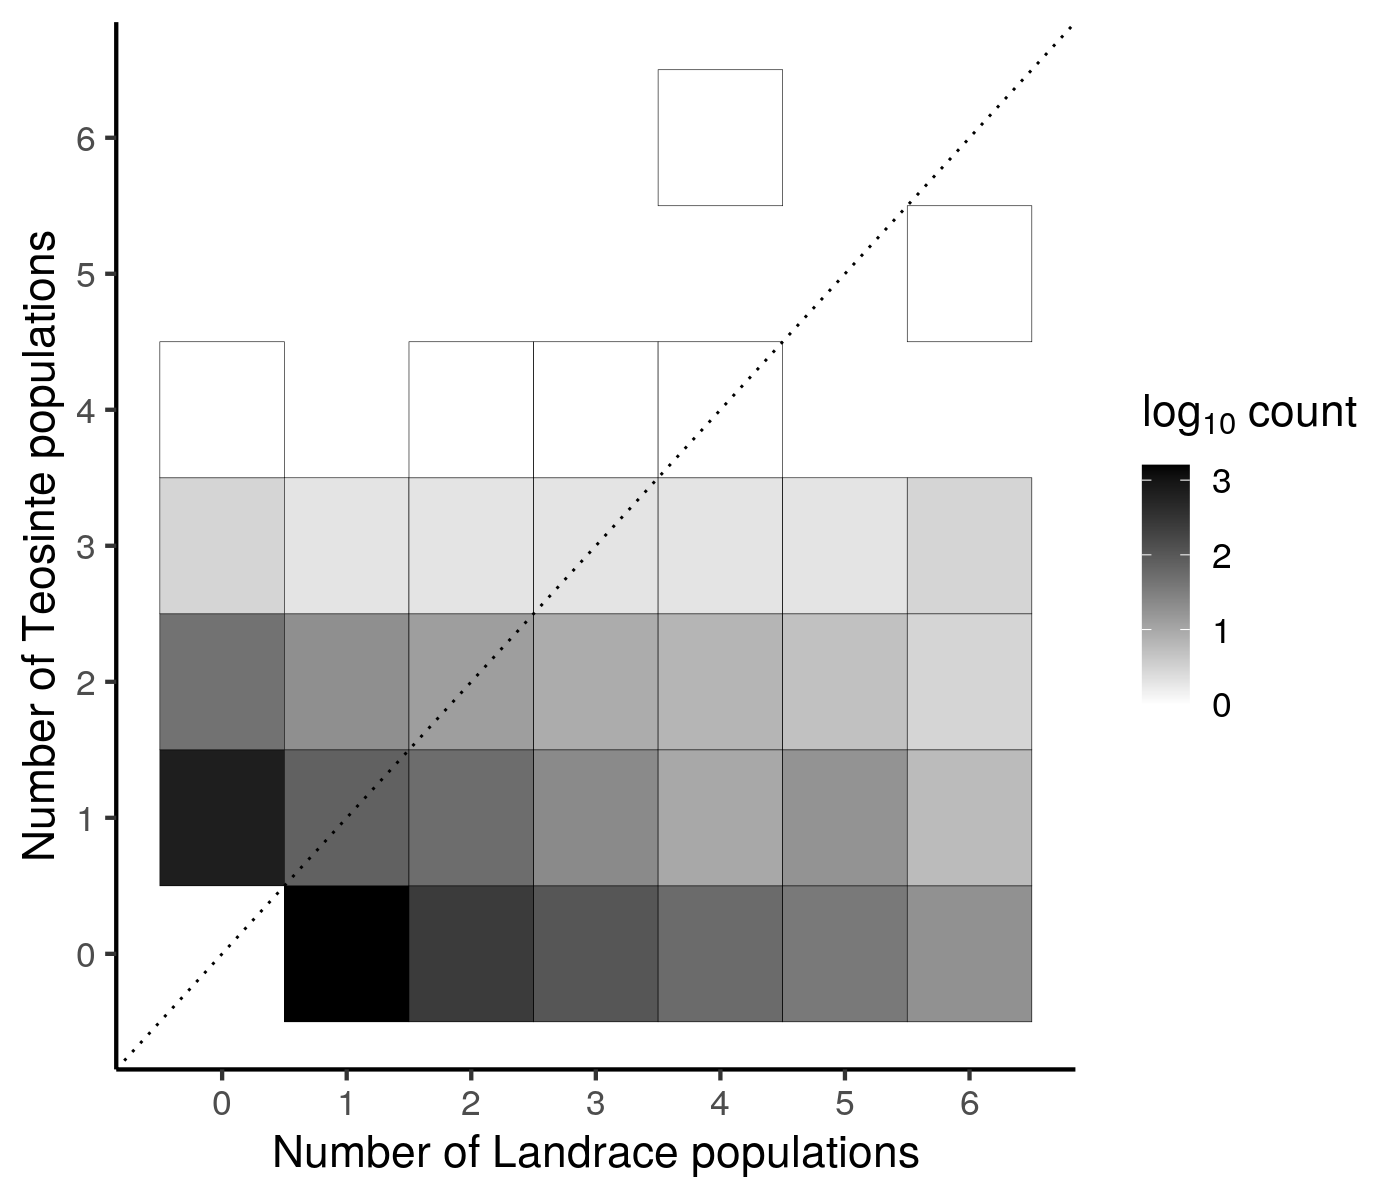

In [22]:
options(repr.plot.width = 7, repr.plot.height = 6 , repr.plot.res = 200)


shareplot <- share_df %>%
    mutate(
        populations = str_remove_all(populations, "(LR--RANDOM2_Palmar_Chico|Teo--RANDOM2_Palmar_Chico)"),
        pop_count = str_count(populations, ",")+1,
        Landraces_count = str_count(populations, "LR"),
        Teosinte_count =  str_count(populations, "Teo")        
        ) %>% 
    filter(Landraces_count != 0 | Teosinte_count != 0) %>%
    group_by(Landraces_count, Teosinte_count) %>% 
    summarise(type_count = n()) %>% 
    ggplot(aes(Landraces_count, Teosinte_count, fill = log10(type_count))) +
    geom_tile(color = "black") +
    scale_fill_gradient(low = "white", high = "black") +
    scale_y_continuous(breaks = 0:8) +
    scale_x_continuous(breaks = 0:8) +
    geom_abline(intercept = 0, slope = 1, lty = 3) +
    xlab("Number of Landrace populations") +
    ylab("Number of Teosinte populations") +
    labs(fill = expression(paste(log[10], " count")))
    
shareplot

# FALSE POSITIVES

False positives were assessed based on the number of sweep regions that overlapped between the 2 replicate palmar chico samples. To account for differences in the total number of sweep regions for each replicate, we averaged the two proportions

$FP =1 - (\frac{n_{S}}{n_{P1}} + \frac{n_{S}}{n_{P2}})/2$

where $n_{S}$ is the number of sweeps shared between the replicates, and $n_{P1}$ and $n_{P2}$ were the number of sweeps in the first and second replicates, respectively. 

Formualted this way, if all sweeps were shared between the two replicates, $FP$ would equal $0$, and if none were shared $FP$ would equal $1$. 

In downstream analyses, we used the average value of $FP$ for the two subspecies, although it was higher for landraces (0.60 and 0.49 for landraces and teosinte, respectively.)


In [ ]:
pc_share <- function(pop1, pop2){
    
    n_pop1 <- nrow(filter(share_df, grepl(pop1, populations)))
    n_pop2 <- nrow(filter(share_df, grepl(pop2, populations)))

    n_pop_share <- 
    share_df %>% 
    filter(grepl(pop1, populations)) %>% 
    filter(grepl(pop2, populations)) %>% 
    nrow()

    tibble(pop1 = pop1, 
           pop2 = pop2, 
           share_count = n_pop_share, 
           count_pop1 = n_pop1, 
           count_pop2 = n_pop2, 
           prop_share = (n_pop_share/n_pop1 + n_pop_share/n_pop2)/2,
           fp = 1 - prop_share
          )
}


pc_share("v5--LR--RANDOM1_Palmar_Chico", "v5--LR--RANDOM2_Palmar_Chico")
pc_share("v5--Teo--RANDOM1_Palmar_Chico", "v5--Teo--RANDOM2_Palmar_Chico")
false_positive <- mean(c(pc_share("v5--LR--RANDOM1_Palmar_Chico", "v5--LR--RANDOM2_Palmar_Chico")$fp,
                       pc_share("v5--Teo--RANDOM1_Palmar_Chico", "v5--Teo--RANDOM2_Palmar_Chico")$fp))
false_positive

full_pair_df <- 
combn(all_pops, 2) %>% 
    t() %>% 
    data.frame() %>%
    set_colnames(c("pop1", "pop2")) %>% 
    pmap_dfr(., function(pop1, pop2){pc_share(pop1, pop2)}) %>%
    rowwise() %>% 
    mutate(populations = paste(pop1, pop2, collapse = " , ")) %>% 
    ungroup() %>% 
    mutate(type = case_when(
               grepl("LR", populations) & grepl("Teo", populations) ~ "both",
               grepl("LR", populations) & !grepl("Teo", populations) ~ "Landraces",
               !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
               TRUE ~ "nan")
          ) %>% 
    separate(pop1, c("ref1", "ssp1", "pop1"), "--") %>% 
    separate(pop2, c("ref2", "ssp2", "pop2"), "--") %>% 
    mutate(geography = case_when(
            ssp1 != ssp2 & pop1 == pop2 ~ "sympatric",
            TRUE ~ "allopatric"
    )) %>%
    full_join(., sweep_counts_df, by = "type") %>%
    arrange(desc(share_count))

head(full_pair_df)


In [ ]:
pair_test_df <- 
full_pair_df %>%
    rowwise() %>% 
    mutate(
        p = -phyper(q = as.integer(share_count*false_positive)-1,
           m = as.integer(min(count_pop1, count_pop2)*false_positive),
           n = as.integer(total_sweeps*false_positive - min(count_pop1, count_pop2)*false_positive),
           k = as.integer(max(count_pop1, count_pop2)*false_positive), lower.tail = FALSE, log.p = TRUE),
        p_lower = -phyper(q = as.integer(share_count*false_positive)-1,
           m = as.integer(min(count_pop1, count_pop2)*false_positive),
           n = as.integer(total_sweeps*false_positive - min(count_pop1, count_pop2)*false_positive),
           k = as.integer(max(count_pop1, count_pop2)*false_positive), lower.tail = TRUE, log.p = TRUE),
        age = case_when(type == "both" ~ "old", TRUE ~ "young")
    ) %>% 
    mutate(pop1 = str_remove_all(pop1, "RANDOM1_"),
           pop2 = str_remove_all(pop2, "RANDOM1_")) %>% 
    left_join(., color_df, by = c("pop1" = "pop")) %>% 
    rename(color_pop1 = color) %>% 
    left_join(., color_df, by = c("pop2" = "pop")) %>% 
    rename(color_pop2 = color)  %>% 
    mutate(
    p = -log10(p.adjust(exp(-p), method = "BY")),
    p_lower = -log10(p.adjust(exp(-p_lower), method = "BY")),
    )

pair_test_df %>% 
    filter(geography == "sympatric") %>% 
    arrange(desc(p))



In [ ]:
leg_df <- 
color_df %>% 
    mutate(pop = str_replace(pop, "LR_|Teo_", "")) %>% 
    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
    mutate(pop = ifelse(pop == "random", "rangewide", pop)) %>% 
    arrange(pop)


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)


plot_pair_df <- 
pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    mutate(pop1 = str_replace_all(pop1, "random", "rangewide"),
           pop2 = str_replace_all(pop2, "random", "rangewide"),
           pop1 = str_replace_all(pop1, "_", " "),
           pop2 = str_replace_all(pop2, "_", " "),
           ssp_pop1 = paste0(ssp1 ," ", pop1),
           ssp_pop2 = paste0(ssp2 ," ", pop2))  %>%  
    ungroup() %>% 
    mutate(pop1_idx = as.numeric(as.factor(pop1))) %>%
    mutate(pop2_idx = as.numeric(as.factor(pop2)))



facet_pair <- plot_pair_df %>% 
    ggplot(aes(ssp_pop1, p, size = share_count, colour = color_pop2)) +
    facet_wrap(~geography+ssp2, scales = "free_y", ncol = 1) +
    geom_point() +
    scale_color_identity(guide = "legend", labels = str_remove_all(leg_df$pop, "random1 "), breaks = leg_df$color) +
    coord_flip() 

plot_pair_df_ALLO <- 
    plot_pair_df %>% 
    filter(geography == "allopatric", ssp1 != ssp2) %>% 
    arrange(share_count)

plot_pair_df_SYMP <- 
    plot_pair_df %>% 
    filter(geography == "sympatric", ssp1 != ssp2) %>% 
    arrange(share_count)


share_pval_plot <- 
ggplot() +
    geom_hline(yintercept = -log10(0.05), lty = 2) +
    geom_point(data = plot_pair_df_ALLO, aes(pop1, p, size = share_count, colour = color_pop2)) +
    geom_point(data = plot_pair_df_SYMP, aes(pop1, p, size = share_count, colour = color_pop2)) +
    geom_point(data = plot_pair_df_SYMP, aes(pop1, p, size = share_count), shape=1, colour = "black", stroke = 2) +
    #geom_segment(data = plot_pair_df_SYMP, aes(x = 0.5, xend = 0.5, y = quantile(p, 0.25), yend = quantile(p, 0.25)), size = 2, colour = "black") +
    #geom_segment(data = plot_pair_df_ALLO, aes(x = 0.5, xend = 0.5 ,y = quantile(p, 0.25), yend = quantile(p, 0.25)), size = 2,colour = "black") +
    scale_color_identity(guide = "legend", labels = str_remove_all(leg_df$pop, "random1 "), breaks = leg_df$color) +
    xlab("Population (Landraces)") +
    ylab("-log10 p value") +
    labs(color="Population (Teosinte)", size = "shared sweep count") +
    coord_flip() +
    theme(axis.text.y=element_blank(), legend.position = "n")


share_pval_plot

# FIGURE 4

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


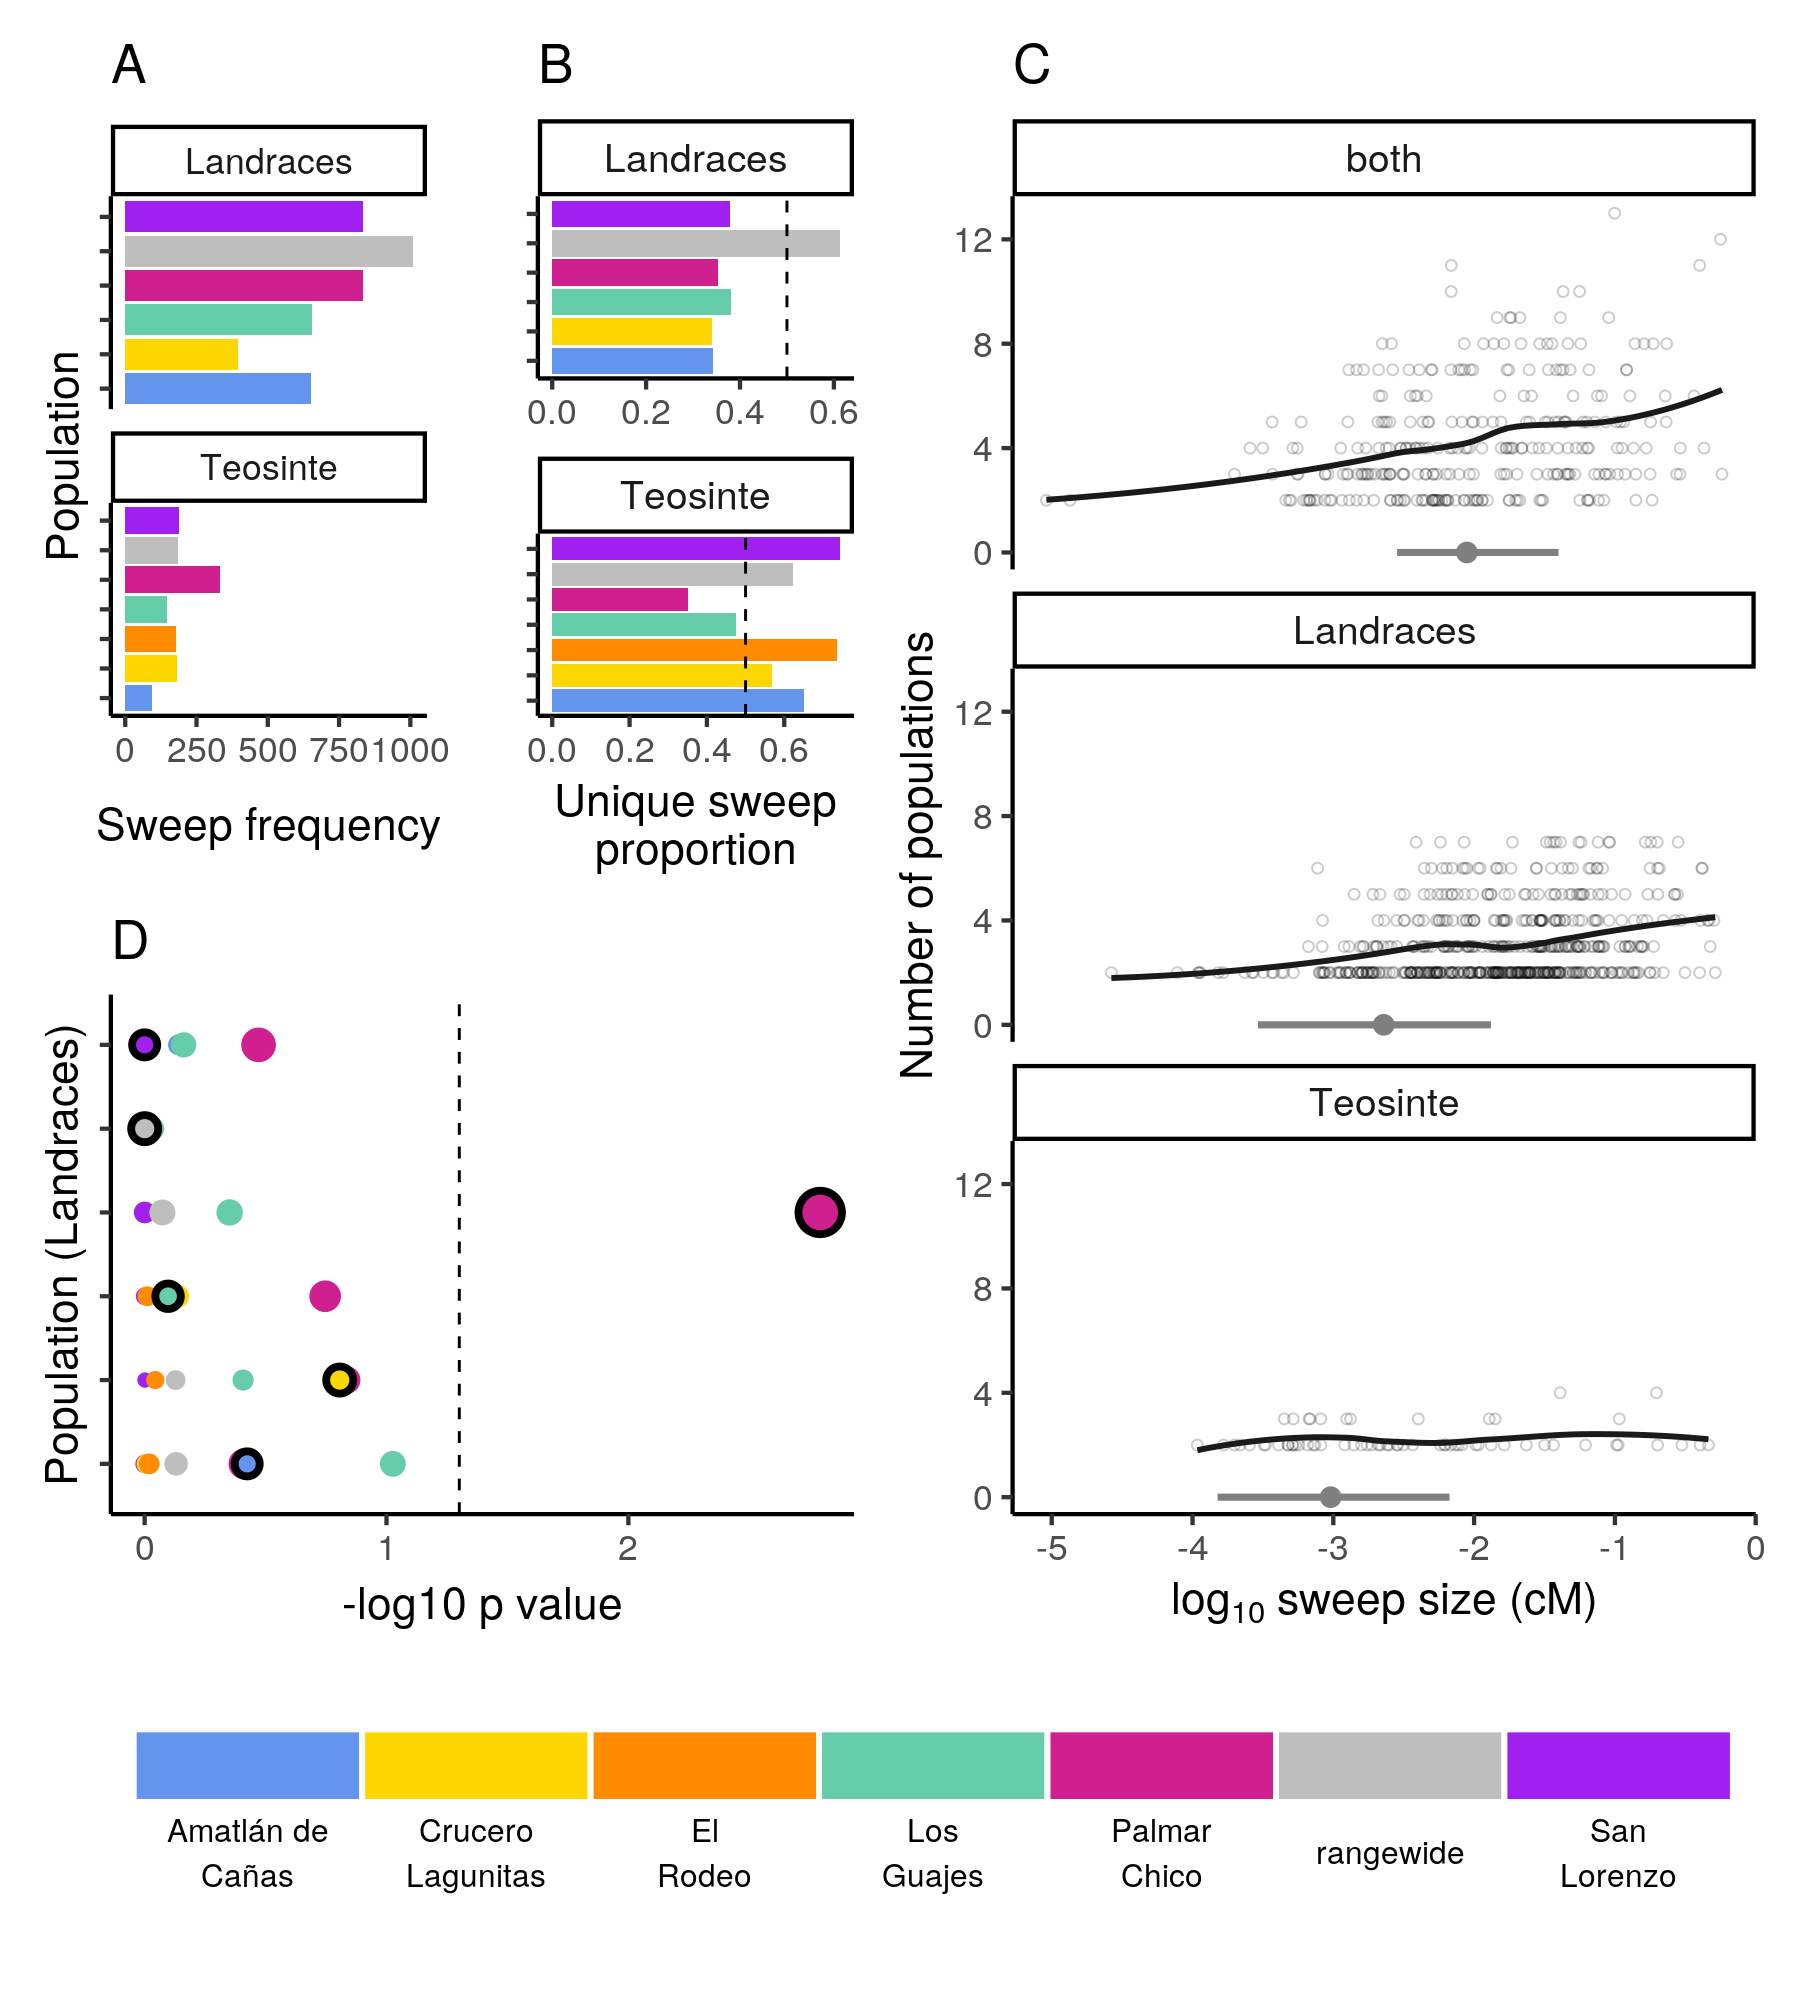

In [21]:
options(repr.plot.width = 9, repr.plot.height = 10, repr.plot.res = 200)

(((((sweep_pop_count + ggtitle("A")) | unique_plot + xlab("") + ggtitle("B") ) / (share_pval_plot + ggtitle("D")))) | 
 (cmshare_plot + ggtitle("C"))) / 
make_legplot(4) + 
plot_layout(heights =  c(10, 2)) +
ggsave("../figures/Figure4.pdf", width = 9, height = 10)

#(cmshare_plot + ggtitle("A") + ((unique_plot + ggtitle("B")) / (share_pval_plot + ggtitle("C")))) / 
#make_legplot(4) + plot_layout(heights = c(10, 2.5)) #+


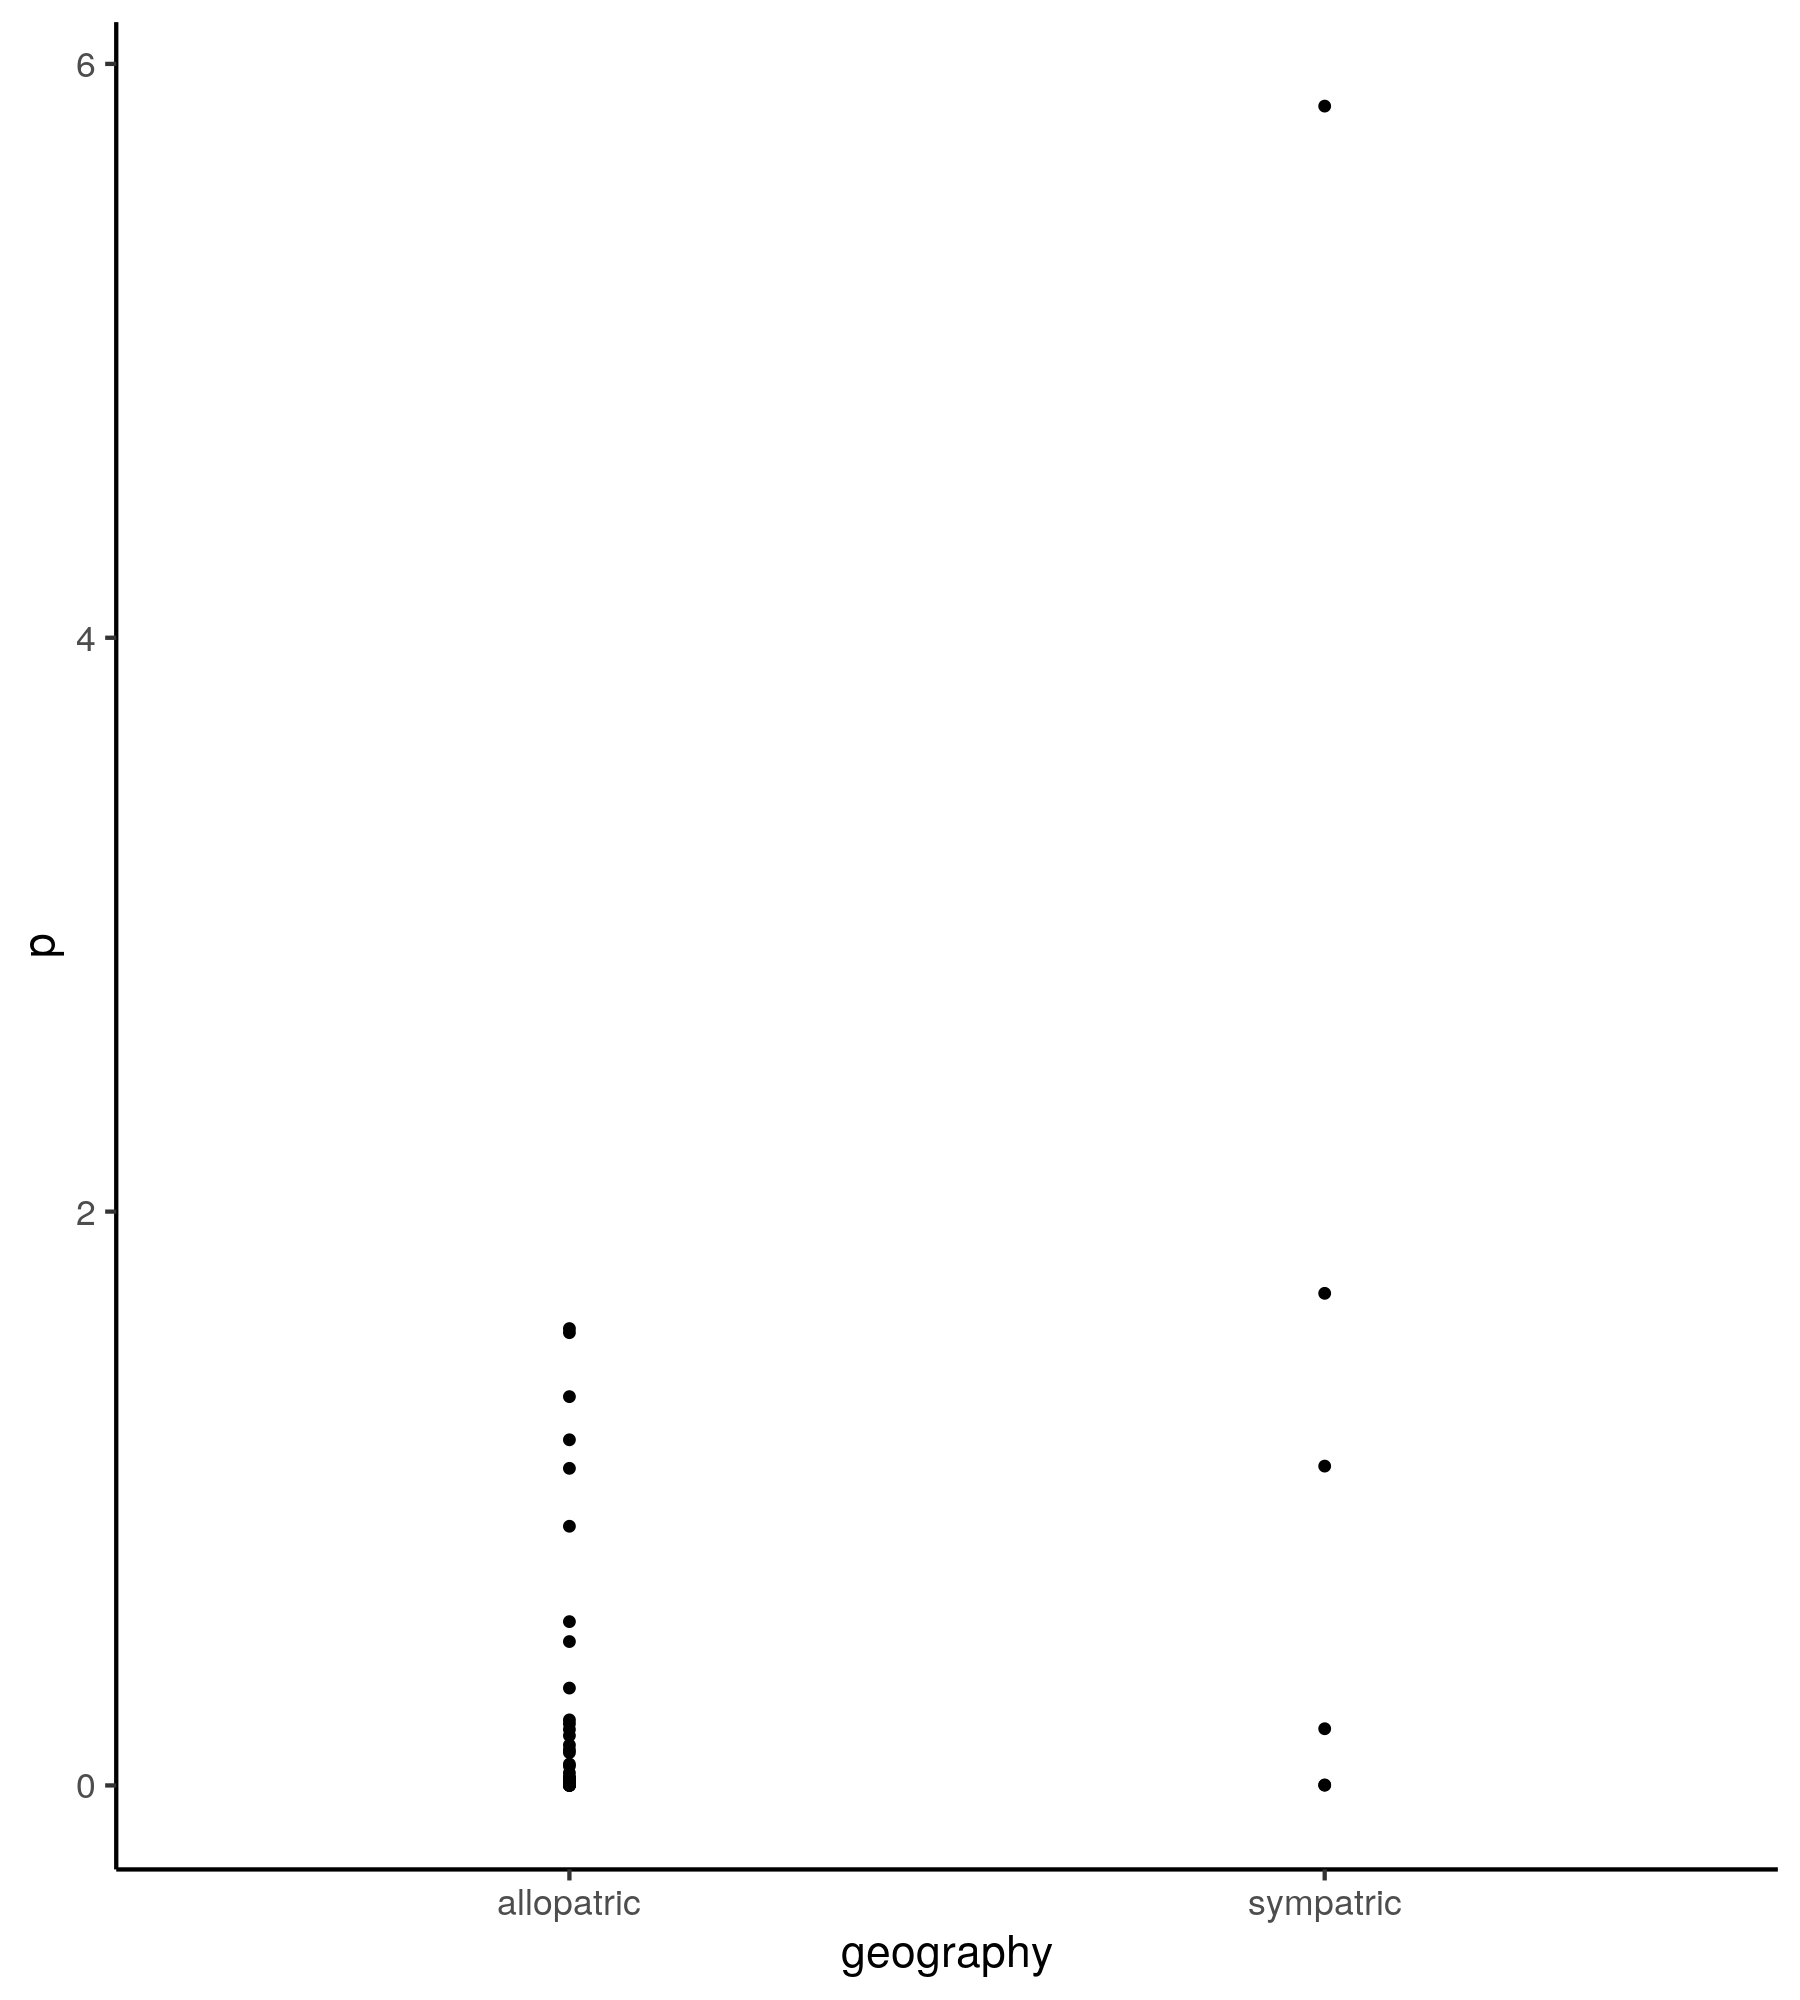

In [21]:
plot_pair_df %>% 
    filter(type == "both") %>%
    ggplot(aes(geography, p)) +
    geom_point()

Rows: 1,000,000
Columns: 14
Delimiter: "\t"
chr [ 1]: chrom
dbl [13]: start, end, v5--LR--Amatlan_de_Canas, v5--LR--Crucero_Lagunitas, v5--LR--Los_Gua...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Warning message:
“Setting row names on a tibble is deprecated.”


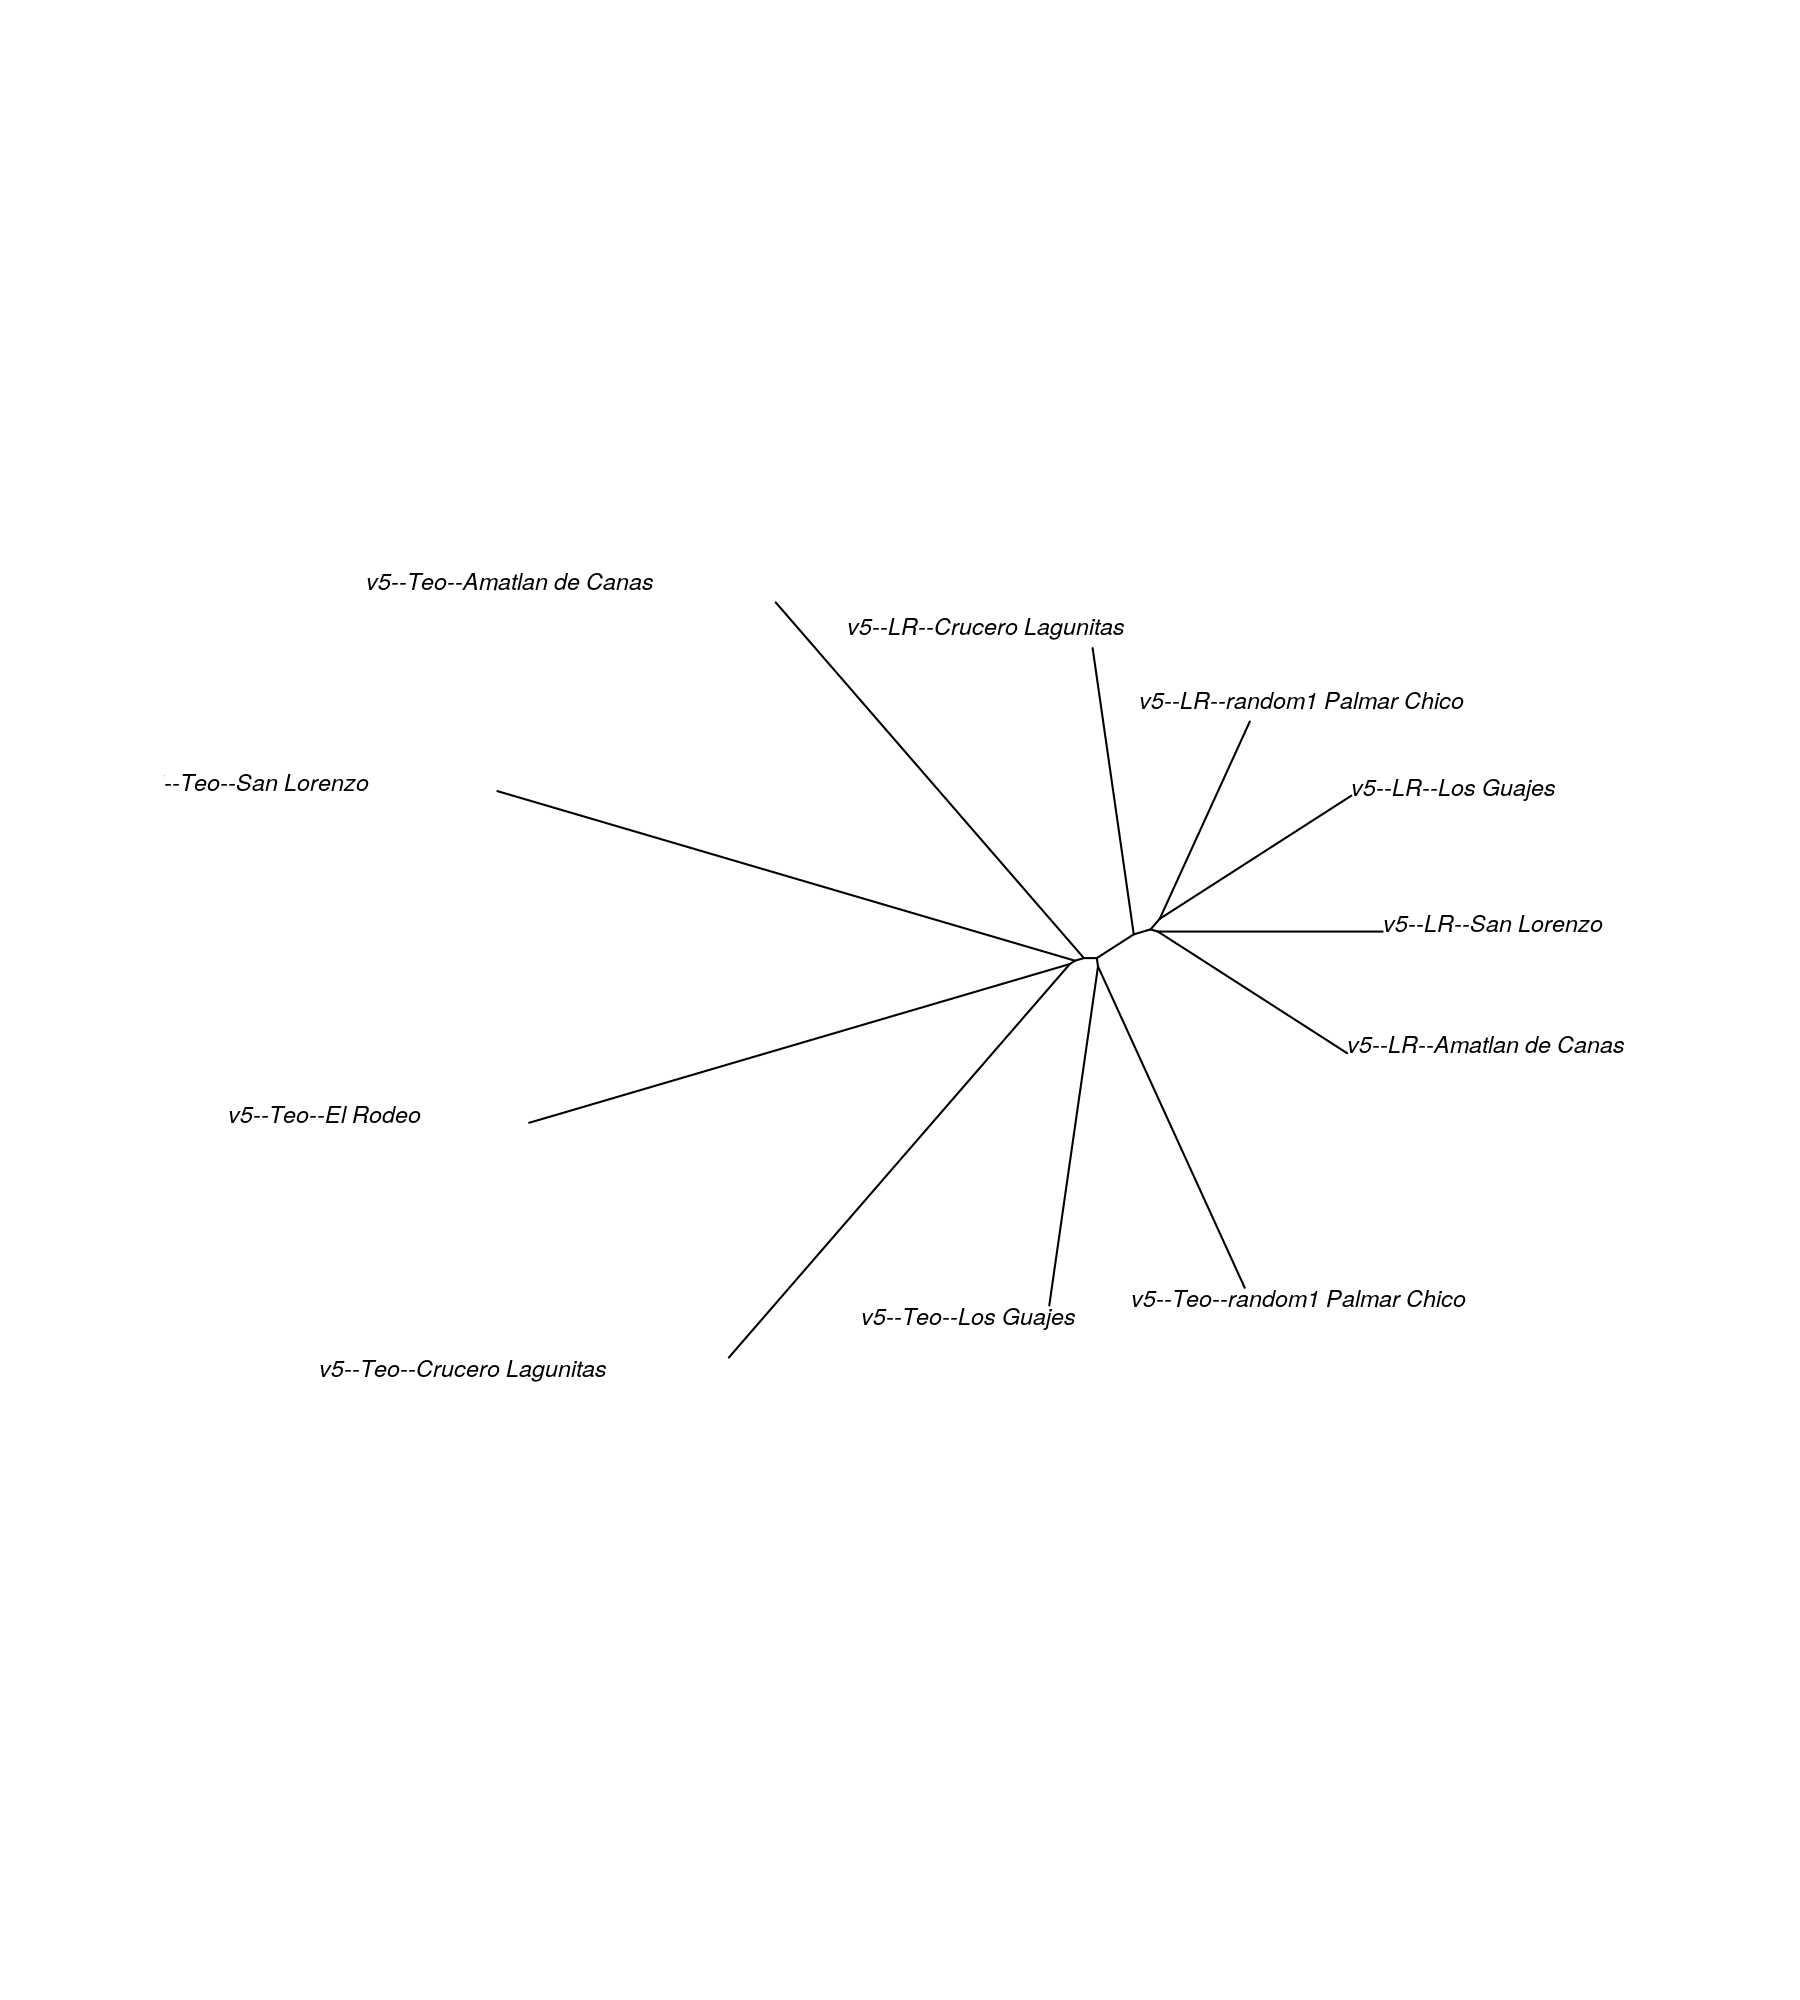

$z.stat
[1] 25556.42

$p
[1] 0.009

$alternative
[1] "two.sided"

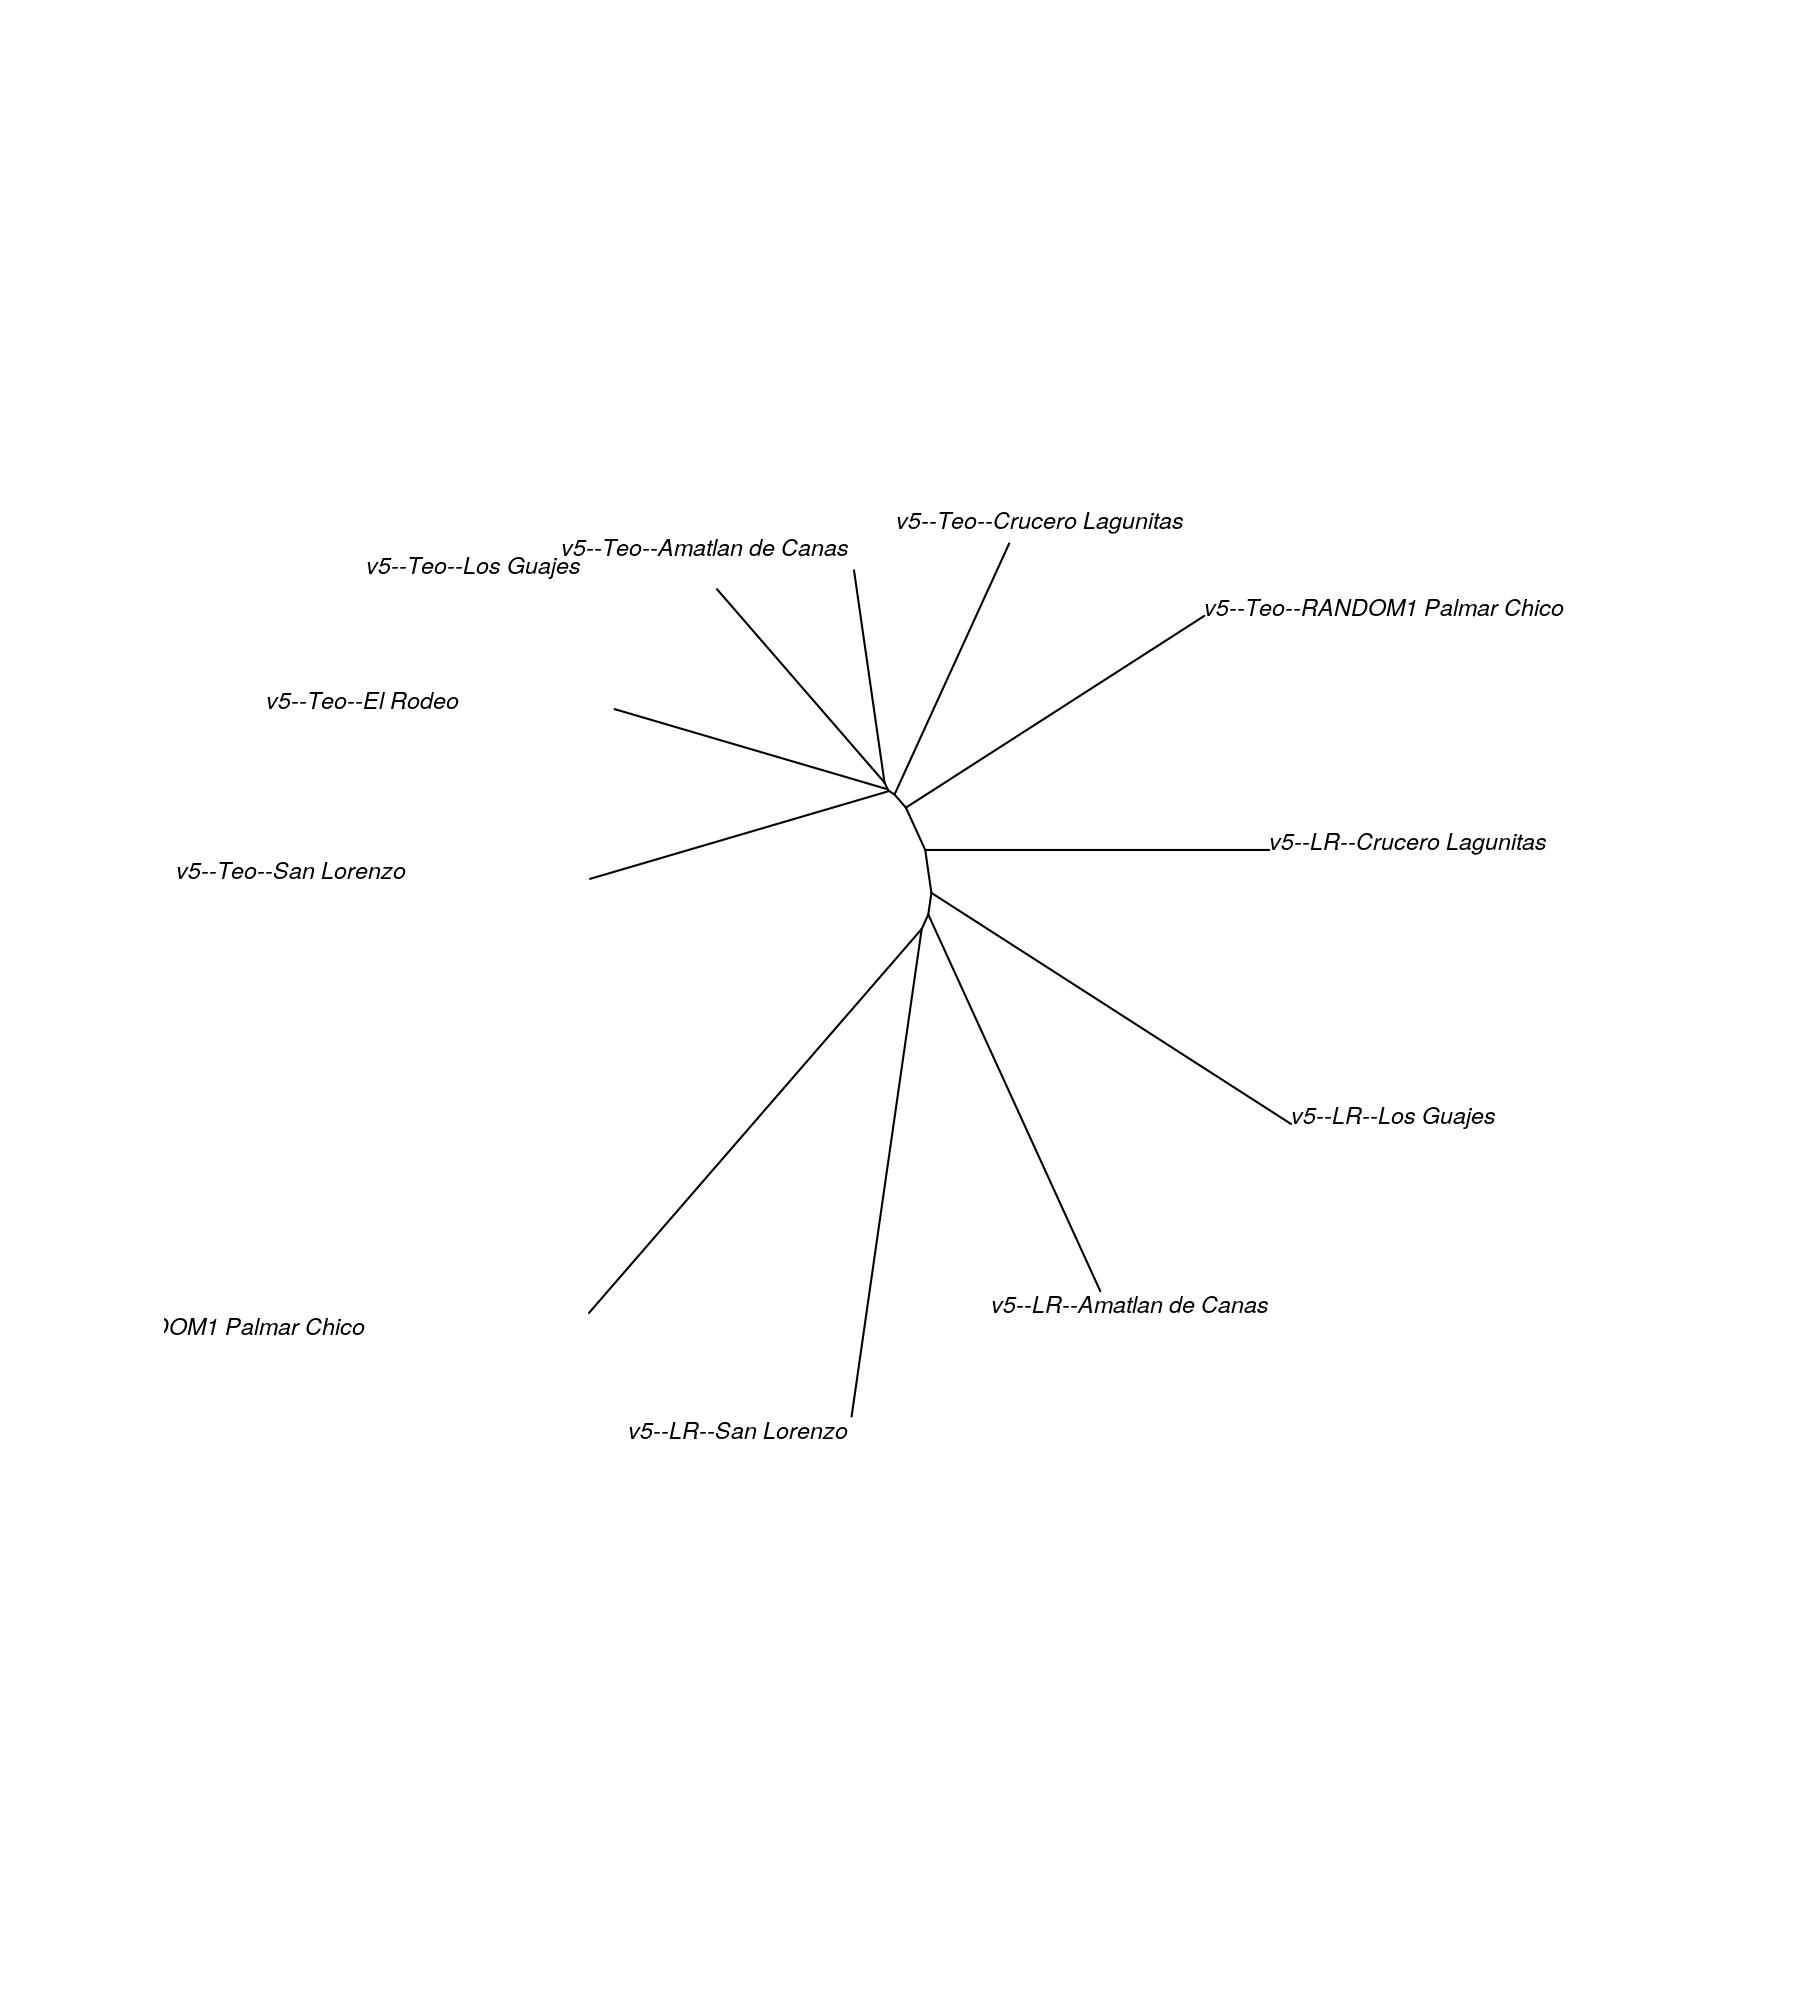

In [22]:
FREQ_POPS2 = c(
    "chrom",
    "start",
    "end",
    "v5--LR--Amatlan_de_Canas",
    "v5--LR--Crucero_Lagunitas",
    "v5--LR--Los_Guajes",
    "v5--LR--random1_Palmar_Chico",
    "v5--LR--San_Lorenzo",
    "v5--Teo--Amatlan_de_Canas",
    "v5--Teo--Crucero_Lagunitas",
    "v5--Teo--El_Rodeo",
    "v5--Teo--Los_Guajes",
    "v5--Teo--random1_Palmar_Chico",
    "v5--Teo--San_Lorenzo"
)

MIN_FREQ <- 1/20

neutral_freqs <- vroom::vroom(file = "../data/rdmc/v5--neutral_freqs.txt",   
    delim = "\t",
    col_names = FREQ_POPS2) %>%
    mutate(varz = apply(dplyr::select(., -c(chrom, start, end)), 1, max)) %>% 
    filter(varz >= MIN_FREQ) %>%
    sample_n(50000) %>% 
    dplyr::select(-varz) 


neut_mat <- neutral_freqs %>% 
    dplyr::select(-c(chrom, start, end)) %>% 
    t() %>% 
    dist()


plot.phylo(nj(neut_mat), type = "unrooted", cex = 0.7)


tree_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--RANDOM1_Palmar_Chico", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--RANDOM1_Palmar_Chico", 
    "v5--Teo--San_Lorenzo"
)

share_aln <- 
map_dfc(1:nrow(share_df), function(c){
    tibble(as.numeric(map_lgl(tree_pops, ~grepl(.x, share_df$populations[c])))) %>% 
    set_colnames(paste0("s", c))
})

rownames(share_aln) <- tree_pops

sweep_mat <- dist(share_aln)
plot.phylo(nj(sweep_mat), type = "unrooted", cex = 0.7)


mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat))


$z.stat
[1] 25556.42

$p
[1] 0.021

$alternative
[1] "two.sided"

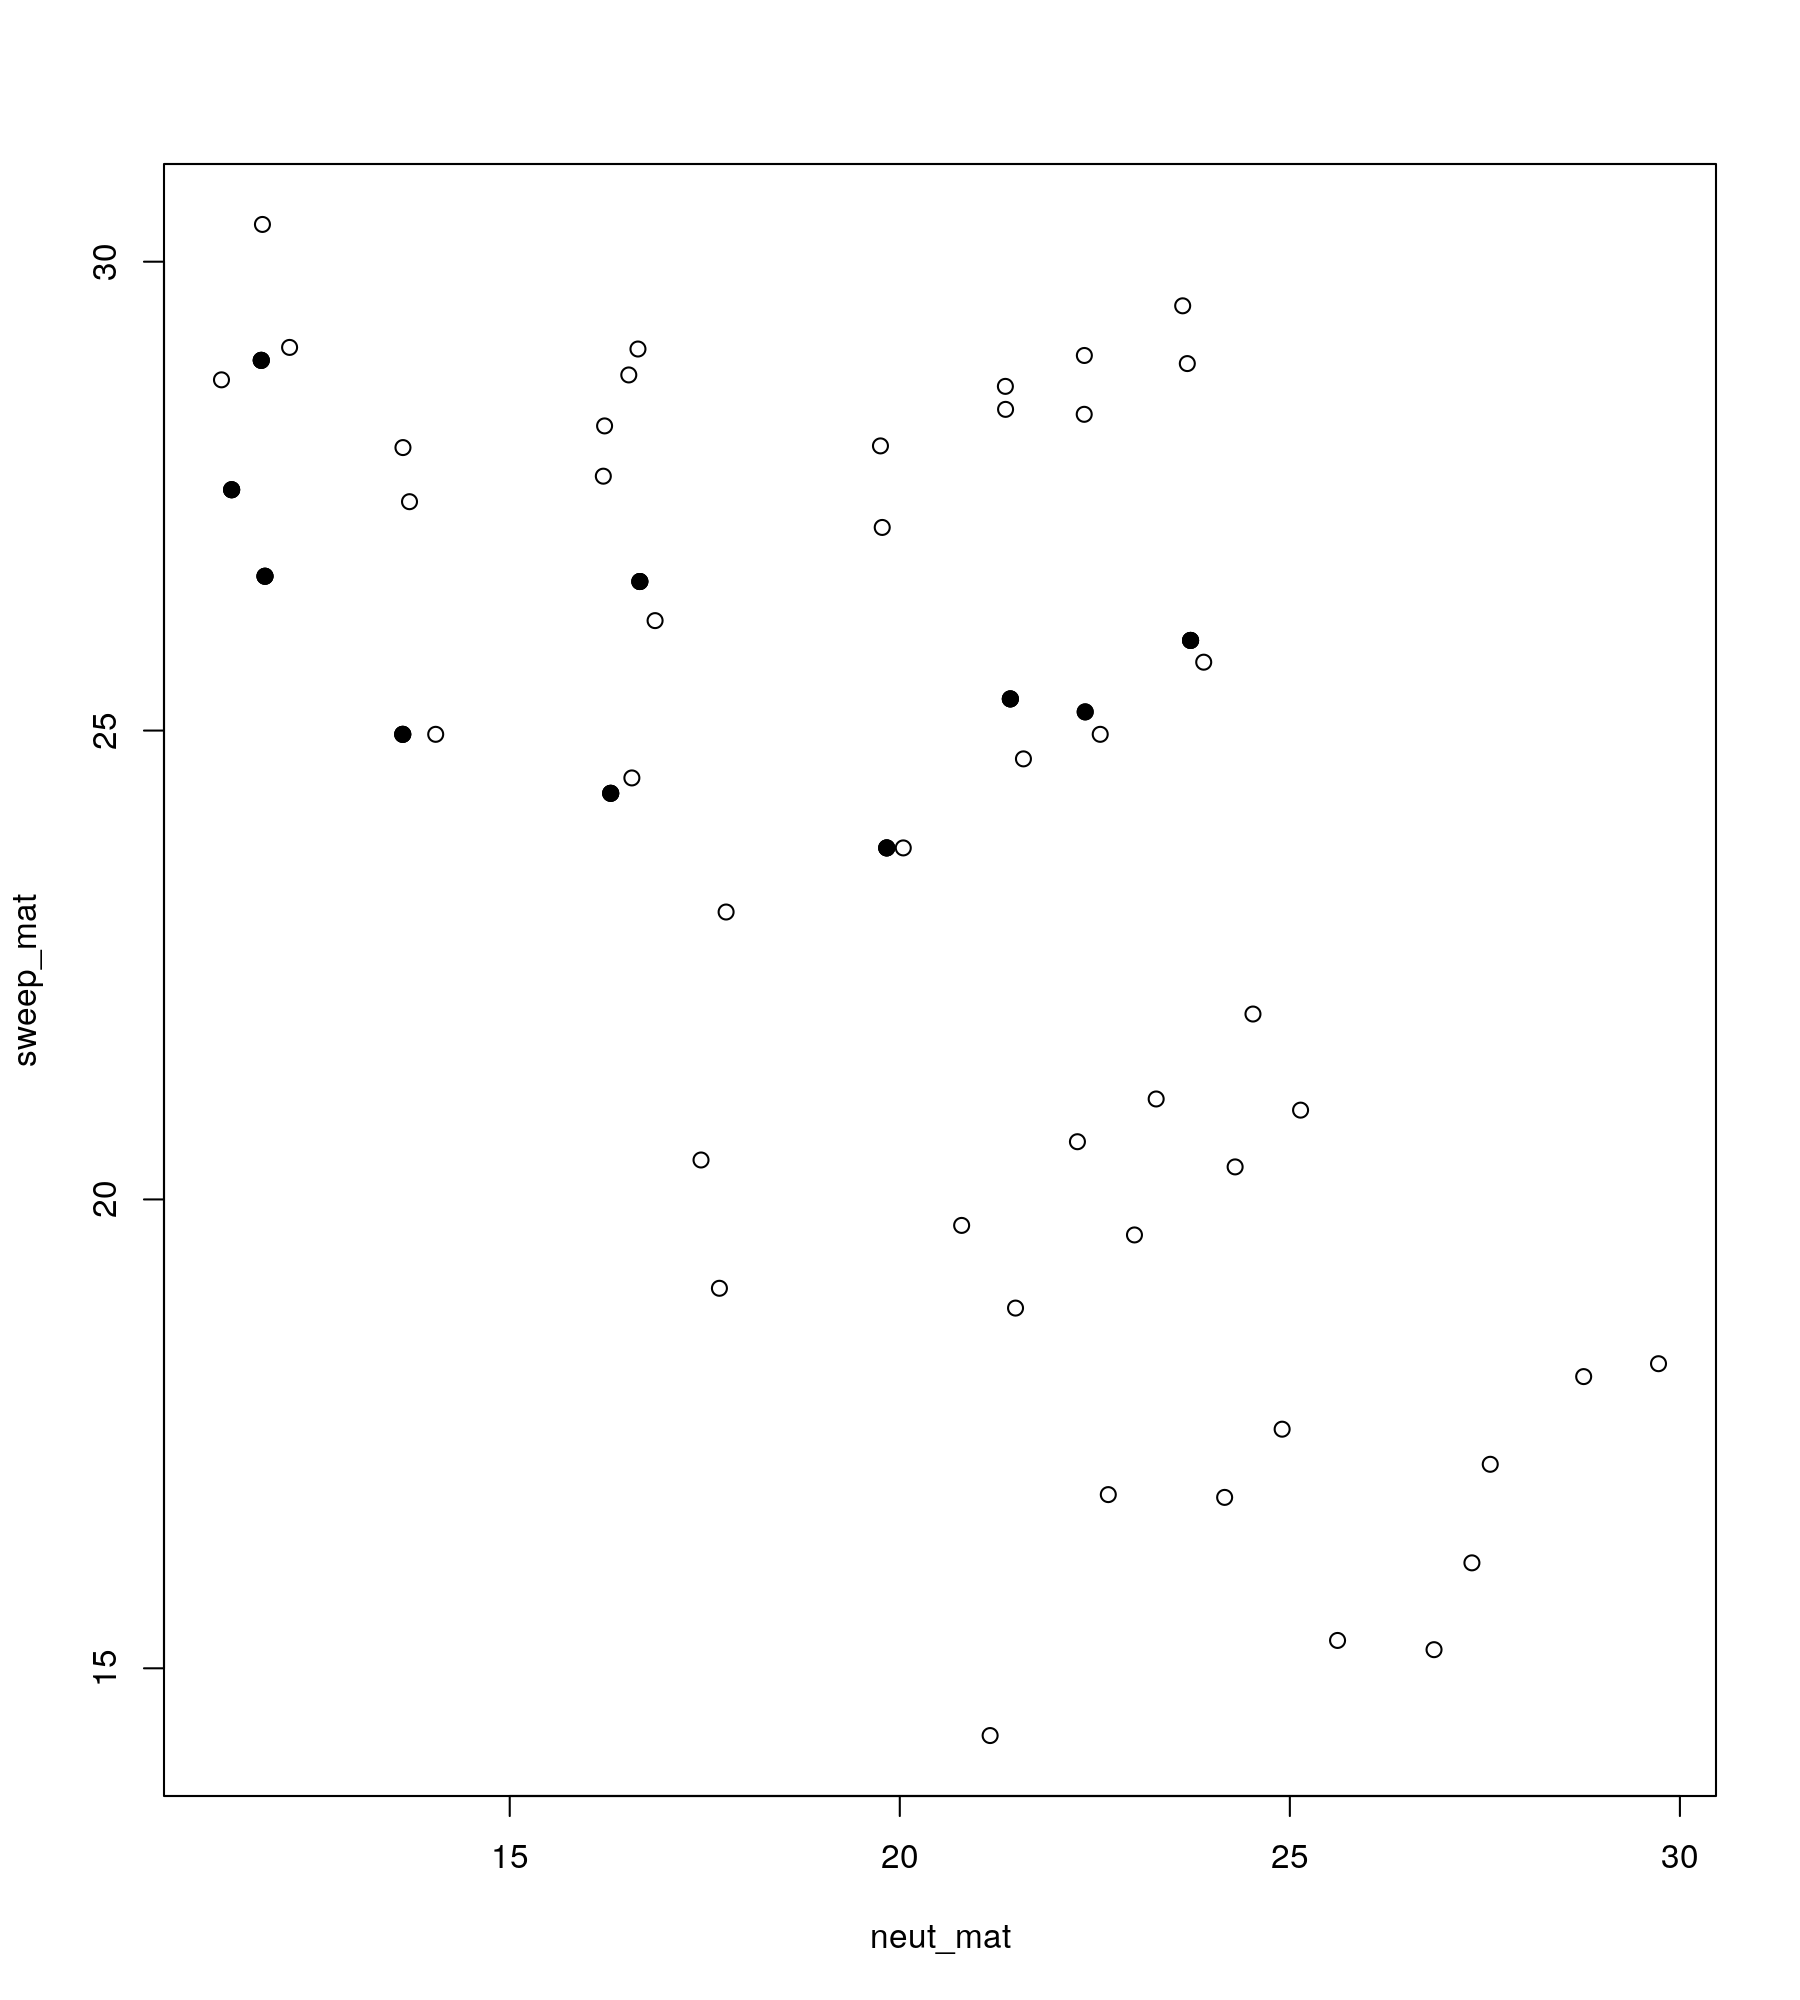

In [23]:
#DO SYMPATRIC PAIRS STAND OUT?
#NO!

simple_pop <- str_remove_all(tree_pops, "(v5--LR--|v5--Teo--)")

plot(neut_mat, sweep_mat)
walk(simple_pop, ~{
    ppair <- which(simple_pop == .x)
    points(as.matrix(neut_mat)[ppair], as.matrix(sweep_mat)[ppair], pch = 19)
})

mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat))

In [24]:
#IS ONE CLADE MORE IMPORTANT THAN THE OTHER?
#IF WE PERMUTE THE LANDRACES AND TEOSINTE SEPARATELY, IS THERE AN IMPACT ON SIGNIFICANCE OF MANTEL TEST!
#ONLY FOR LANDRACES! TEOSINTE POPULATIONS ARE EXCHANGEBLE, 
#SO SIGNAL IS COMING FROM AMOUNT OF SHARING WITHIN LANDRACES AND BETWEEN LANDRACES AND/OR TEOSINTES!


permute_ssp <- function(n_permute = 100, neut_mat, sweep_mat, ssp_labels = c("LR", "Teo"), return_mean = F){
    
    mt1 <- map_dbl(1:n_permute, ~mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat)[c(sample(which(grepl(ssp_labels[1], tree_pops))), which(grepl(ssp_labels[2], tree_pops))),])$p)
    mt2 <- map_dbl(1:n_permute, ~mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat)[c(which(grepl(ssp_labels[1], tree_pops)), sample(which(grepl(ssp_labels[2], tree_pops)))),])$p)

    p_df <- 
    bind_rows(
        tibble(ssp = ssp_labels[1], p = mt1),
        tibble(ssp = ssp_labels[2], p = mt2)
    
    )
    
    if(return_mean){
        return(group_by(p_df, ssp) %>% summarise(mean_p = mean(p)))
    } else {
        return(p_df)
    }
}

permute_ssp(n_permute = 100, neut_mat = neut_mat, sweep_mat = sweep_mat, ssp_labels = c("LR", "Teo"), return_mean = T)

,ssp,mean_p
,<chr>,<dbl>
1,LR,0.18232
2,Teo,0.00796


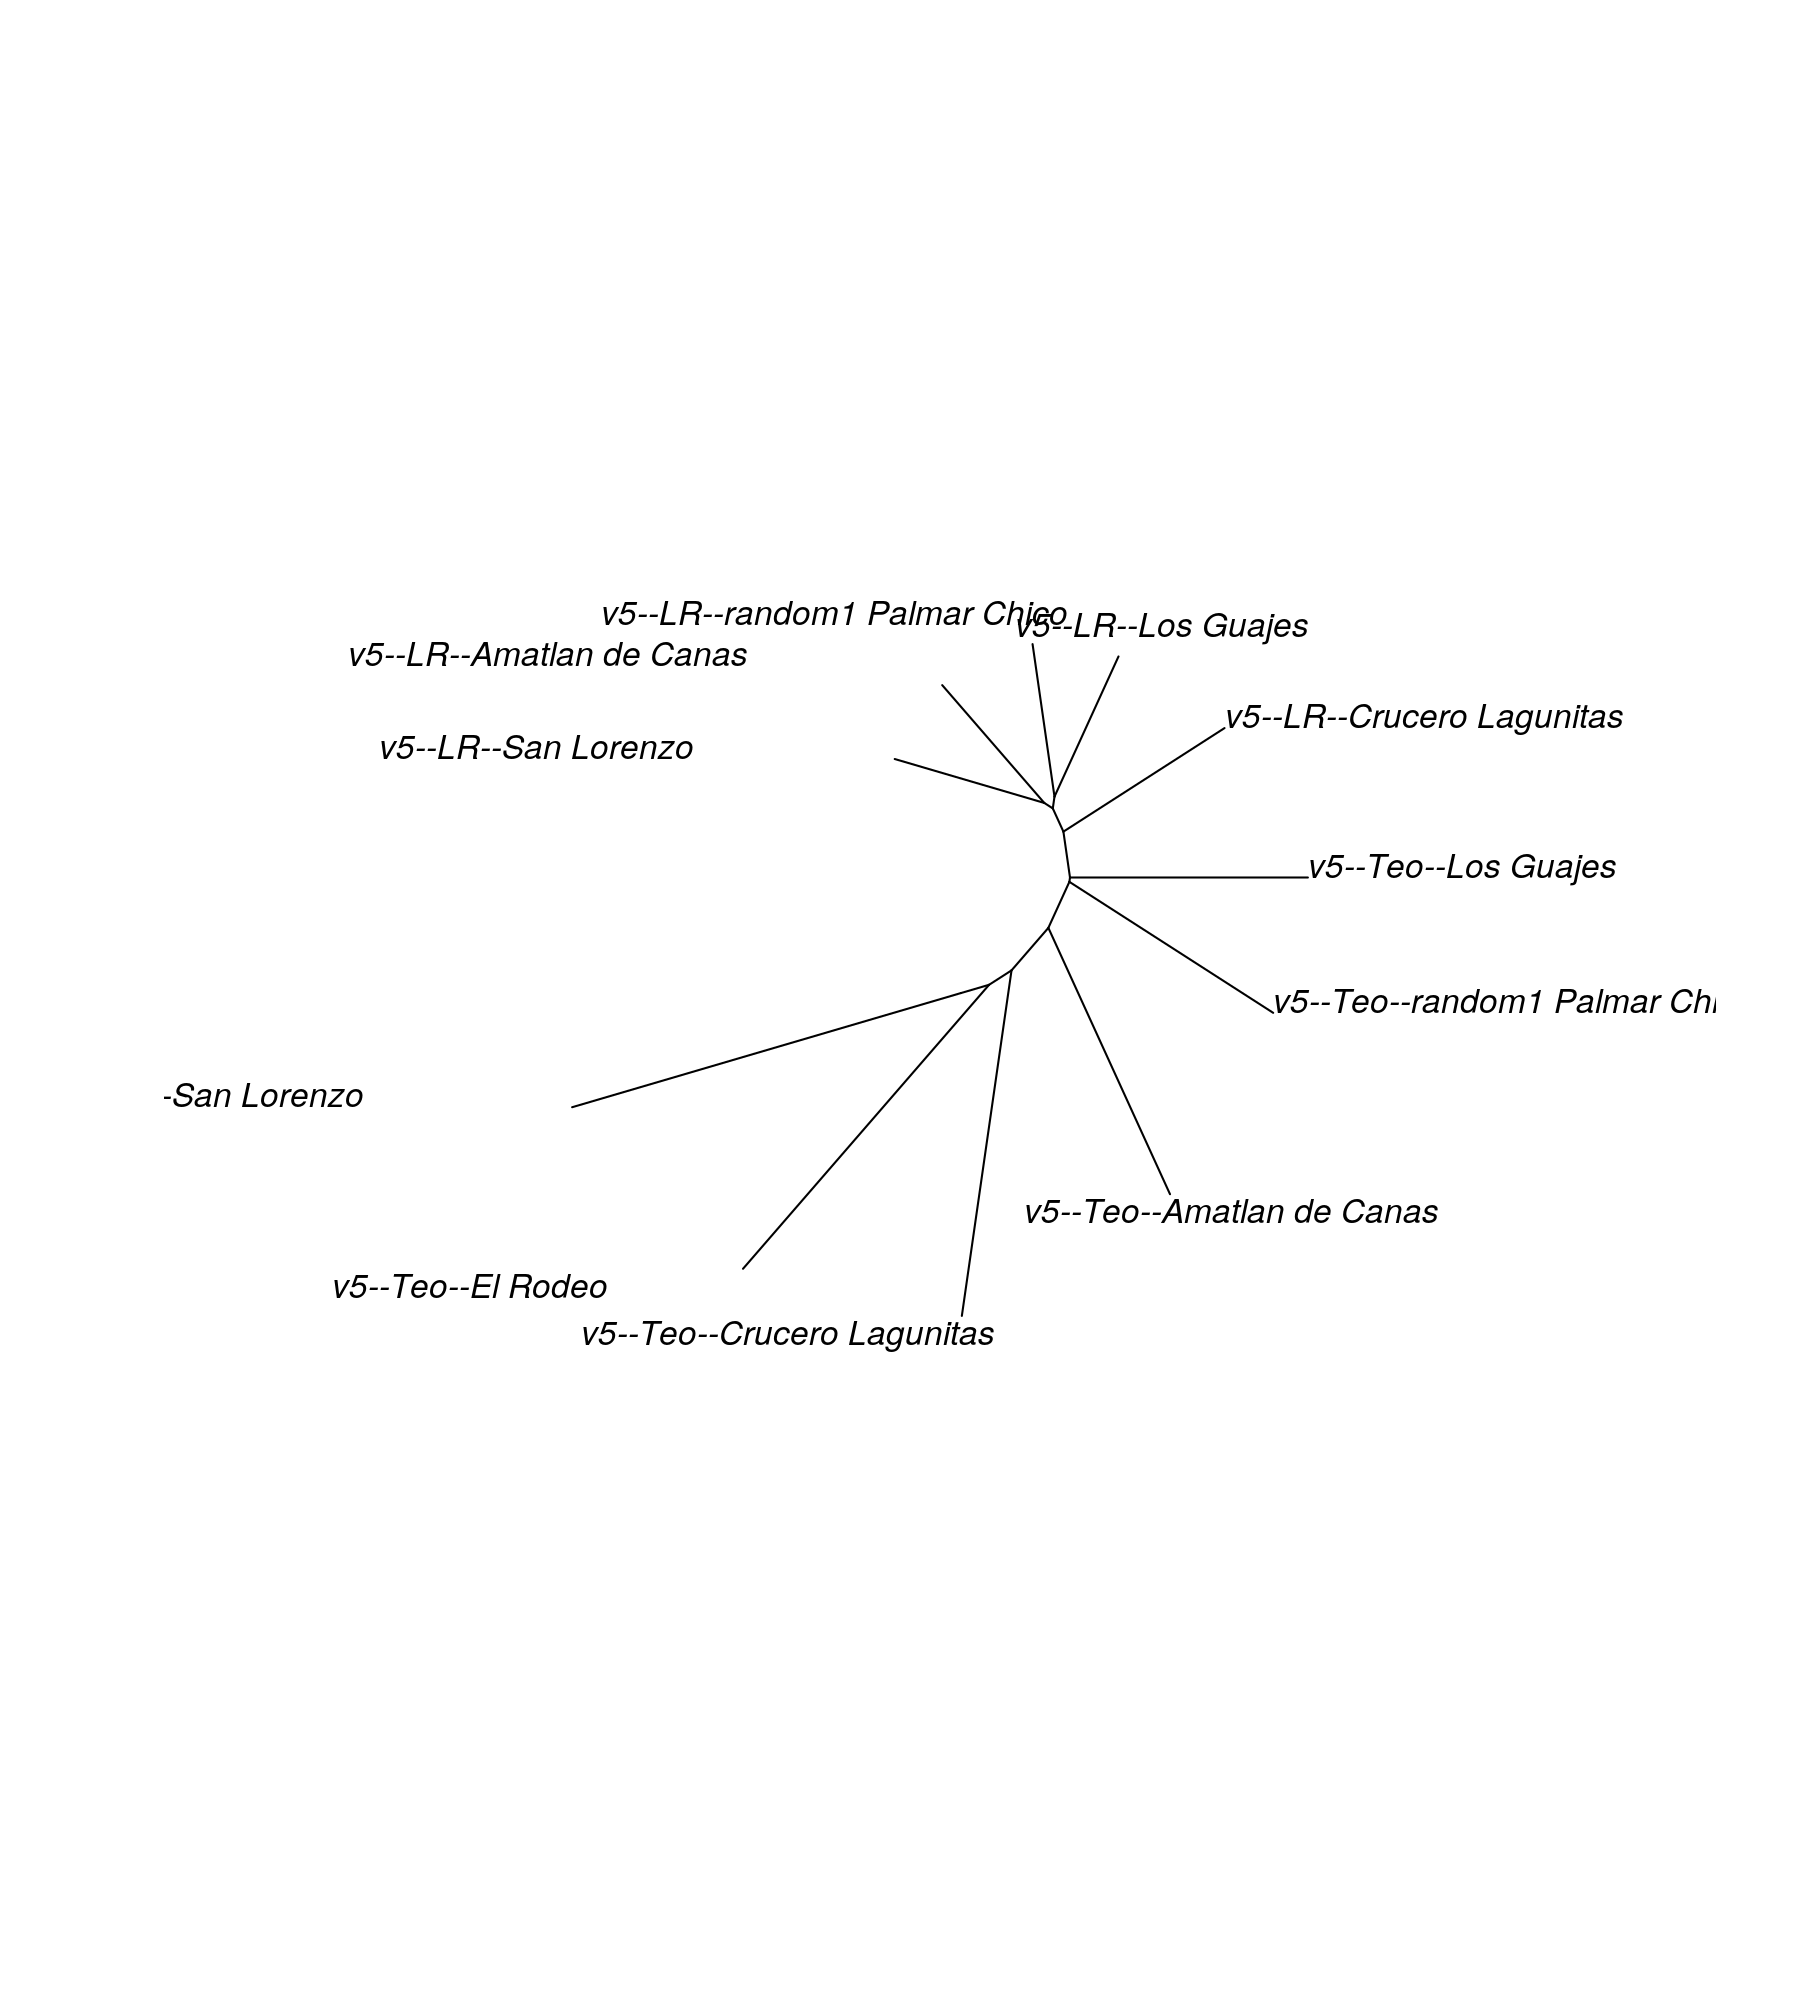

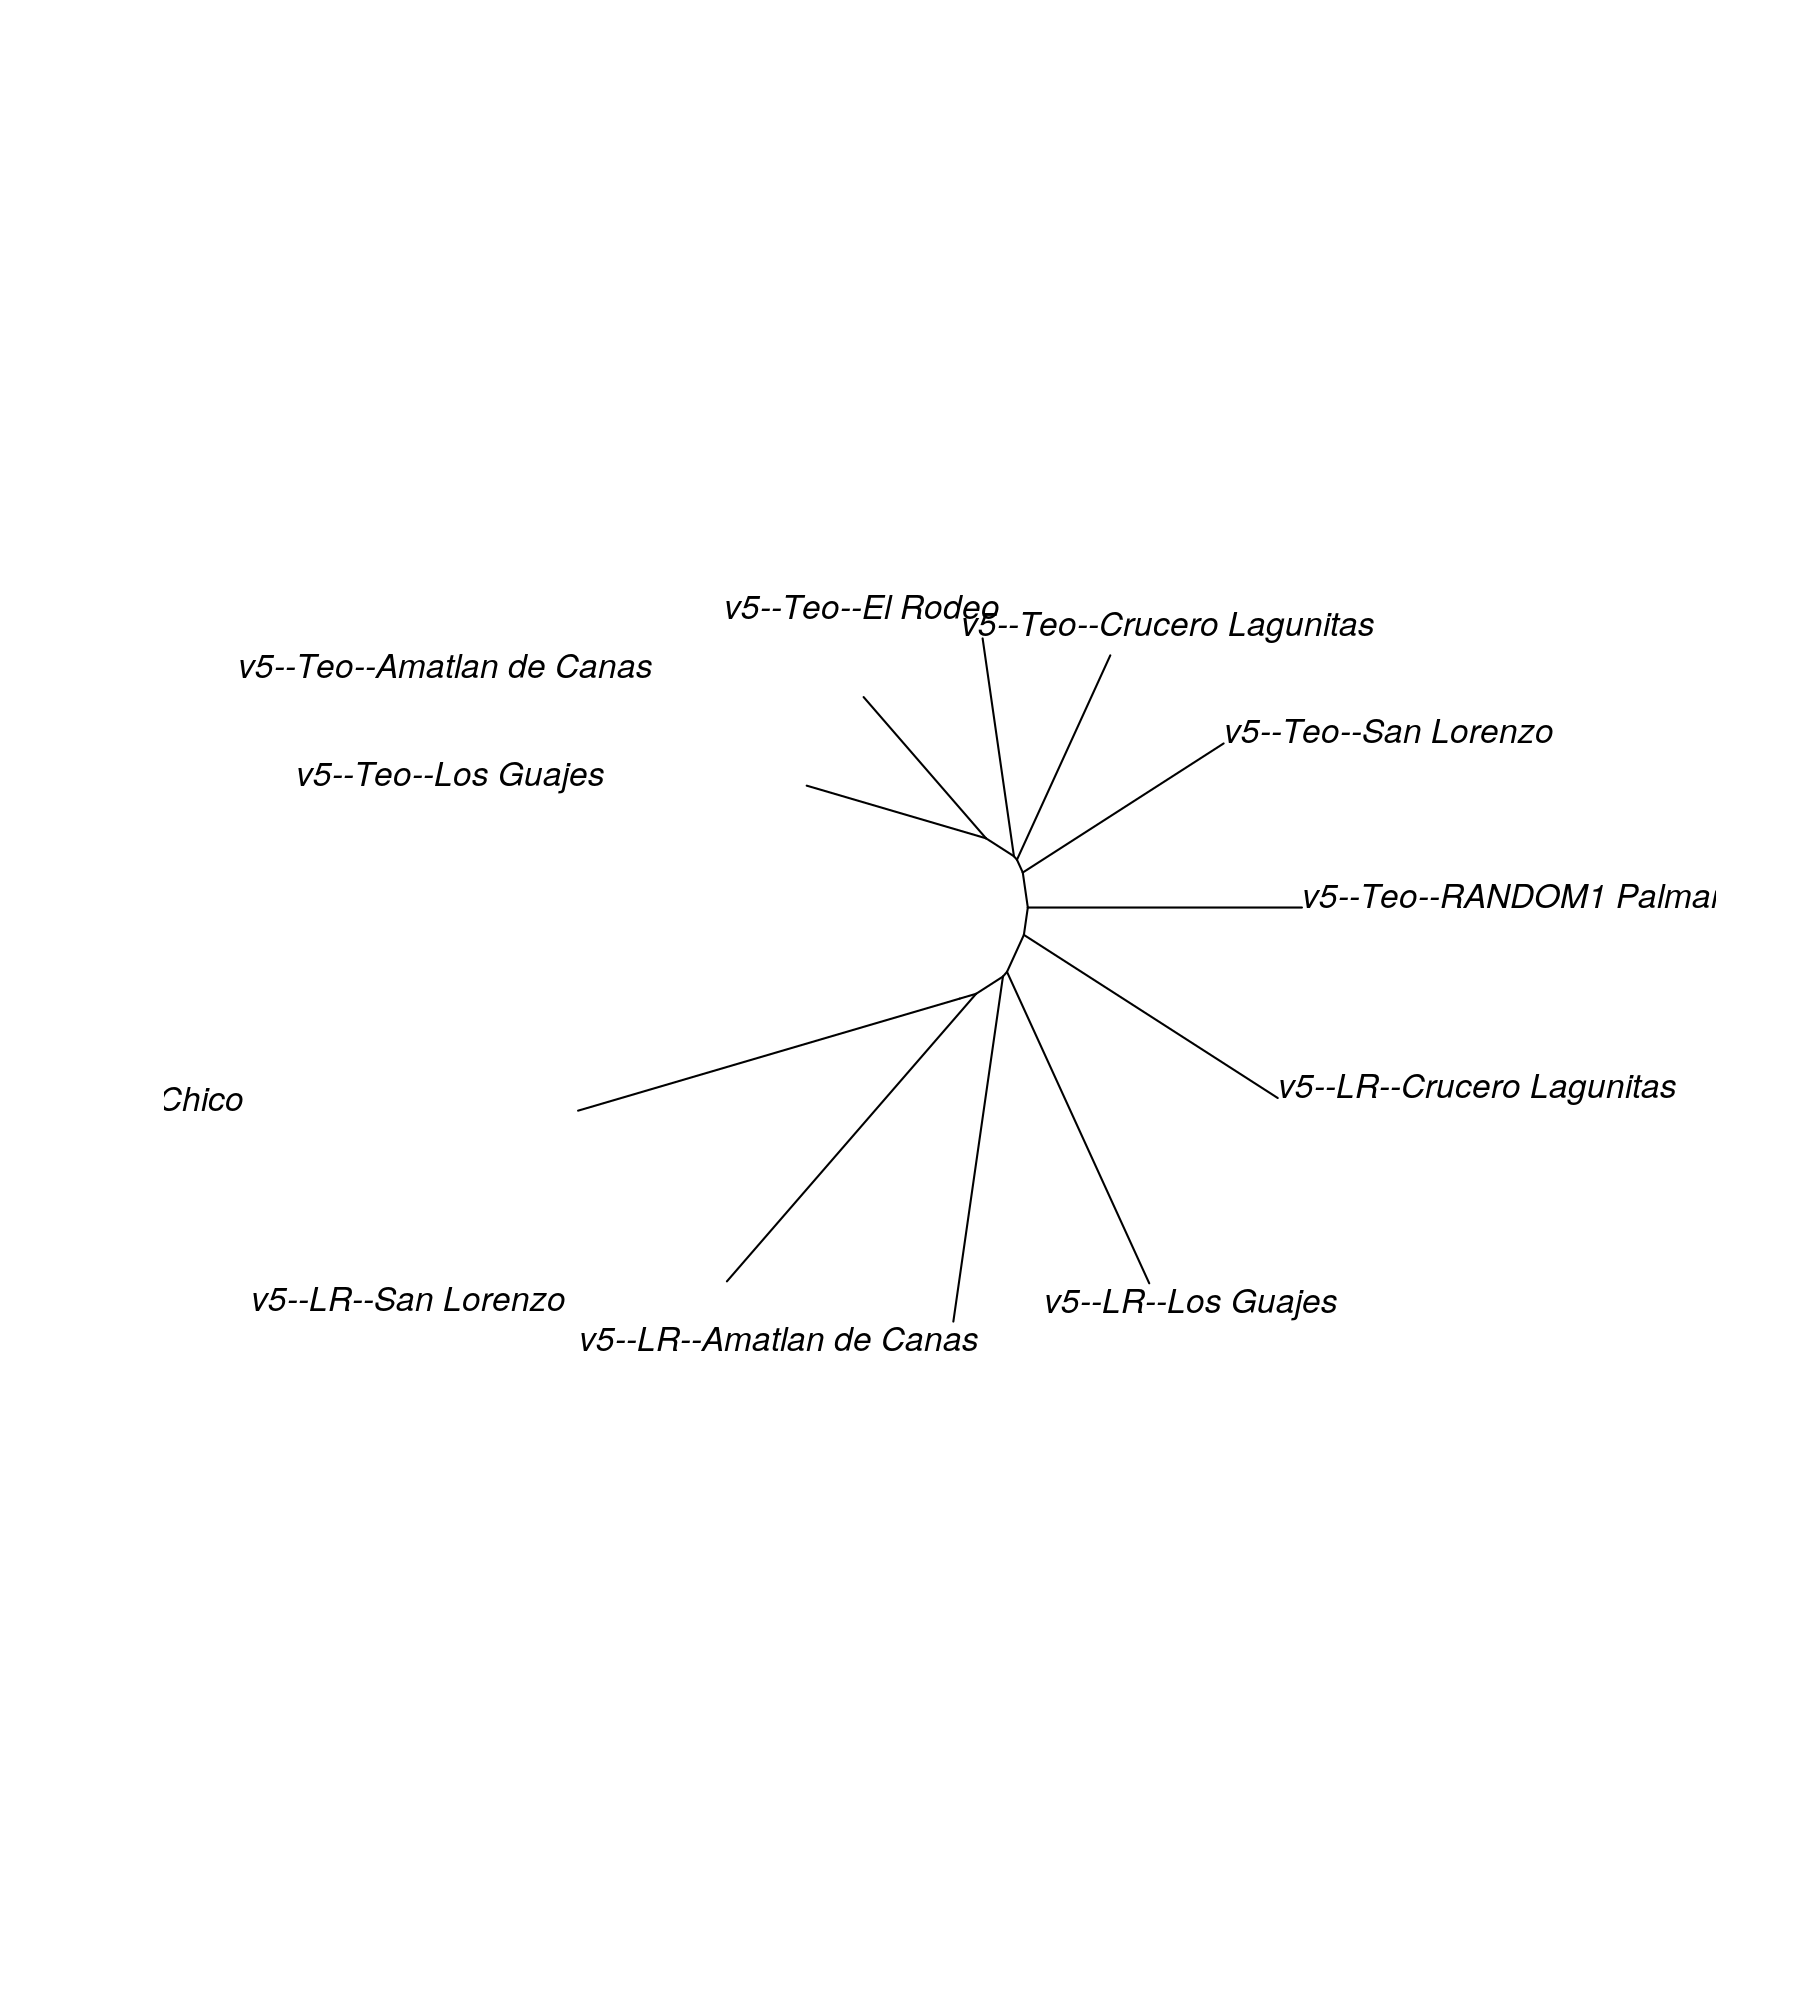

In [25]:
plot(as.phylo(hclust(neut_mat)), type = "unrooted")
plot(as.phylo(hclust(sweep_mat)), type = "unrooted")

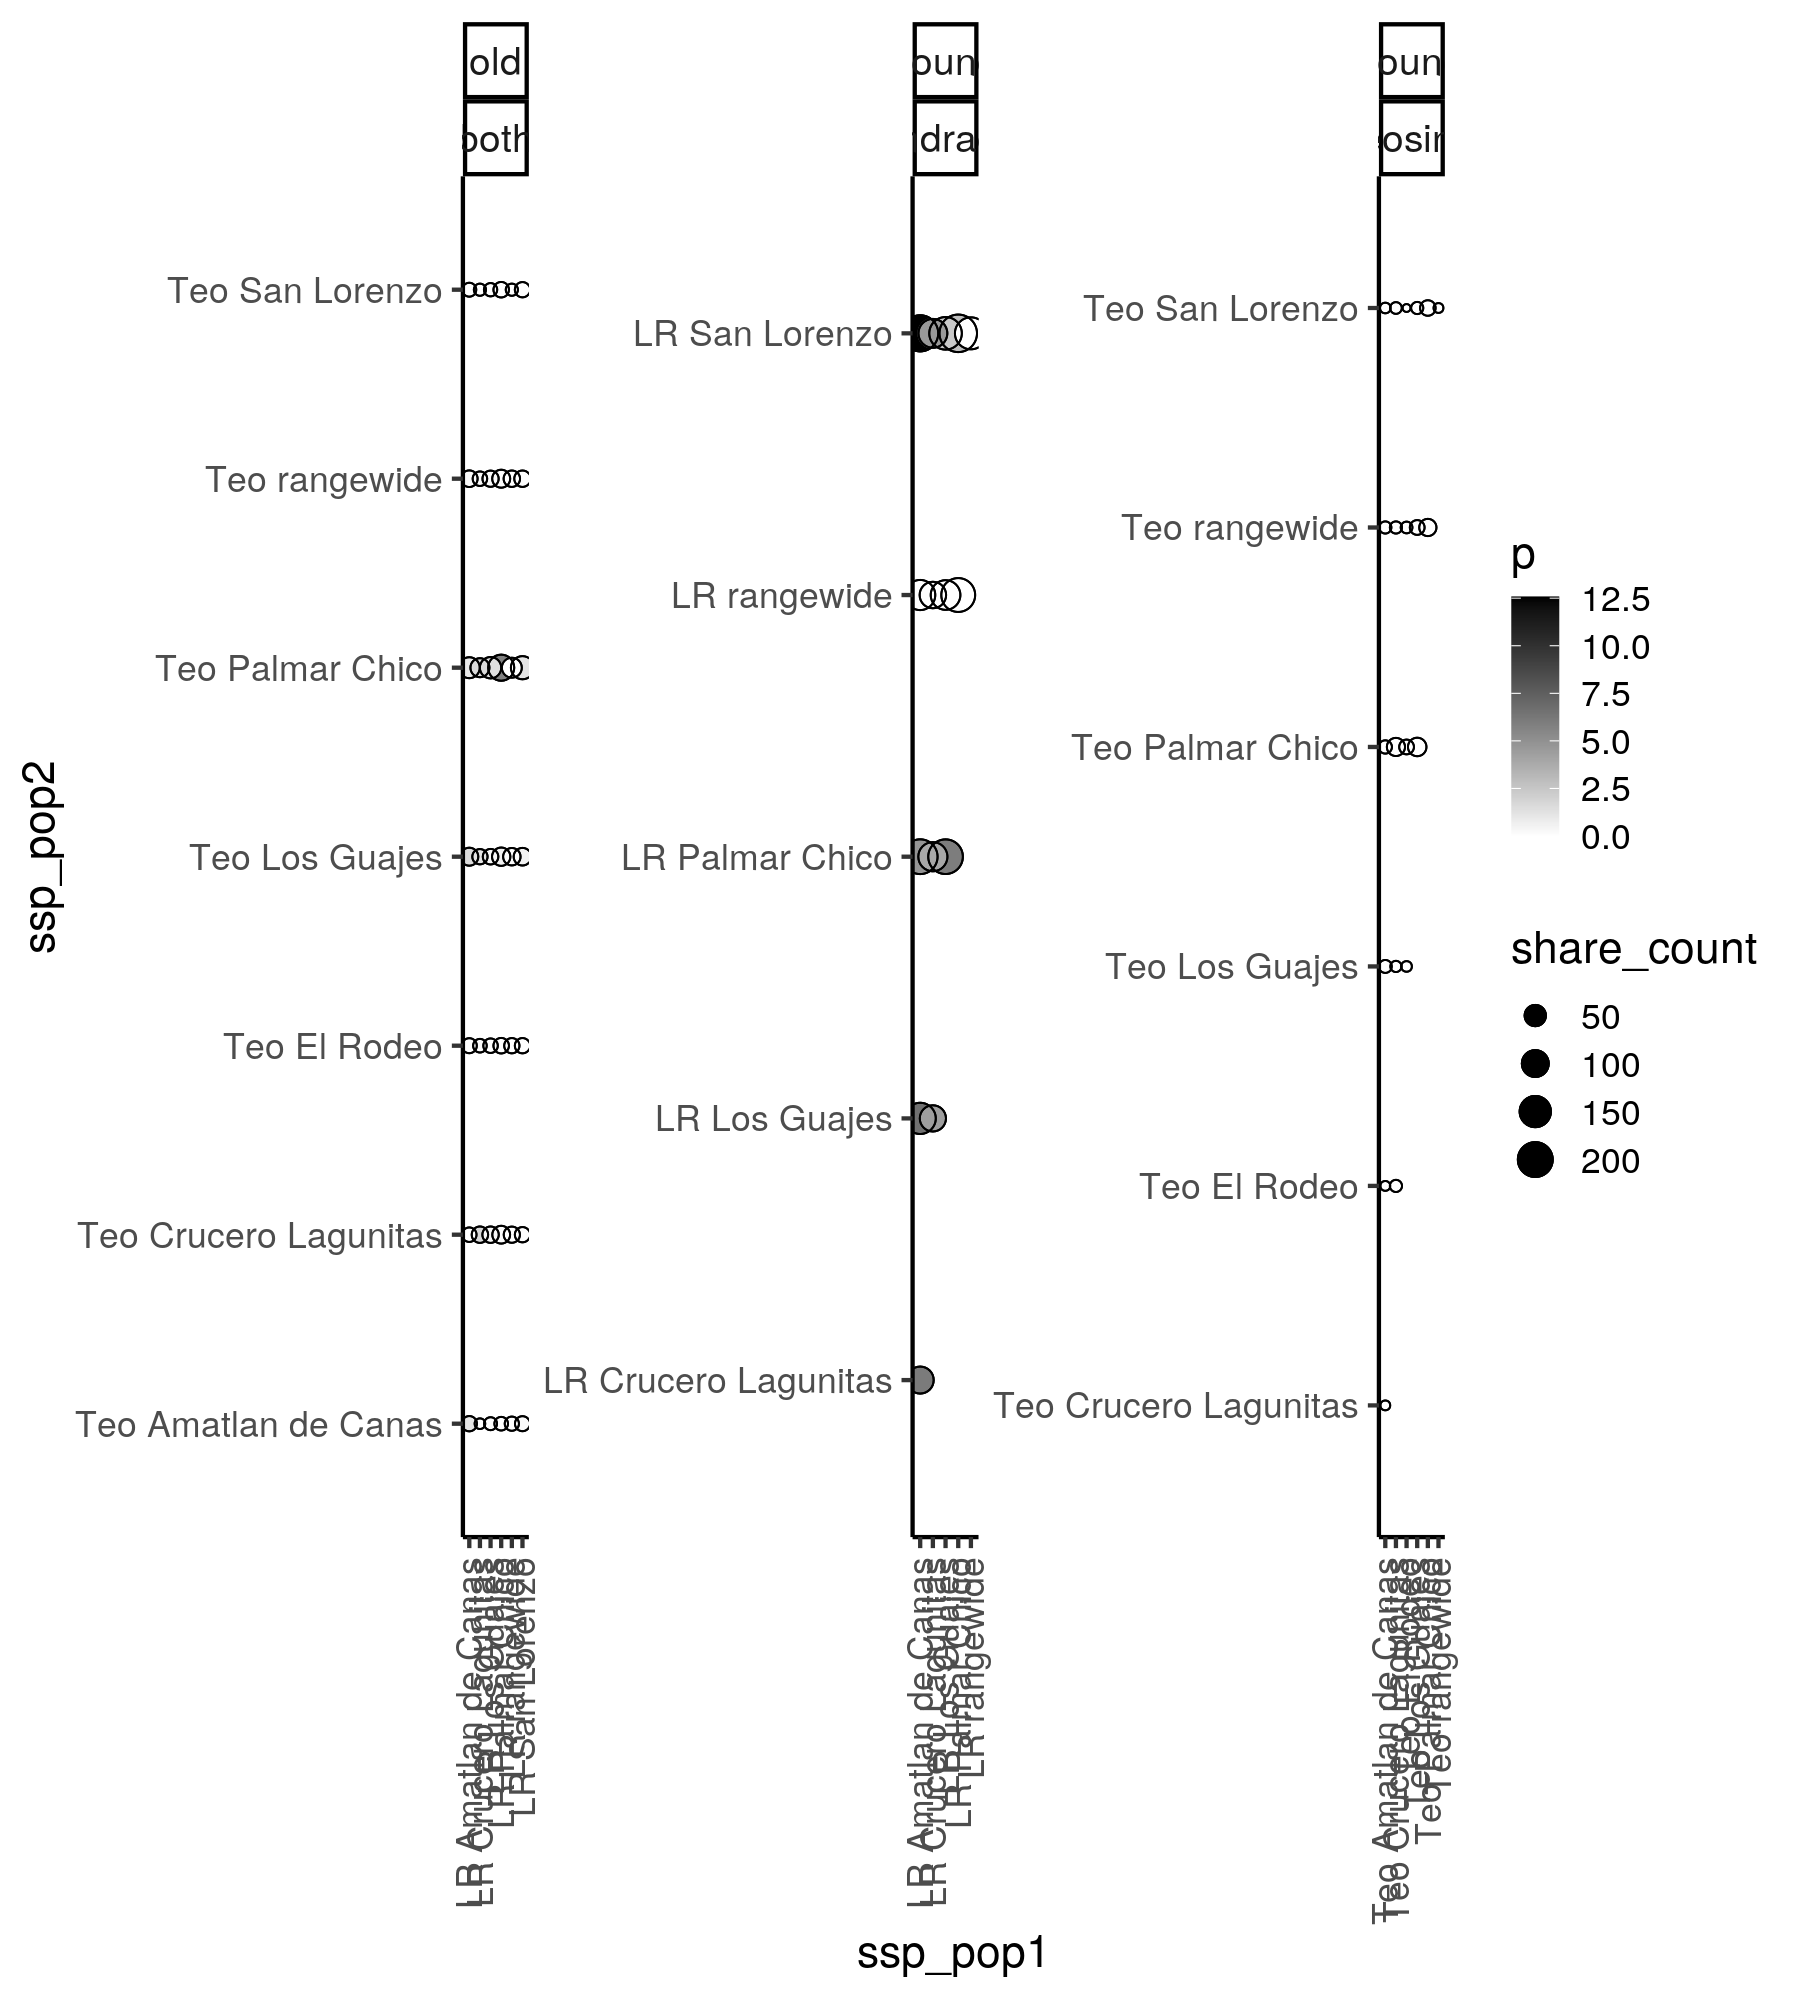

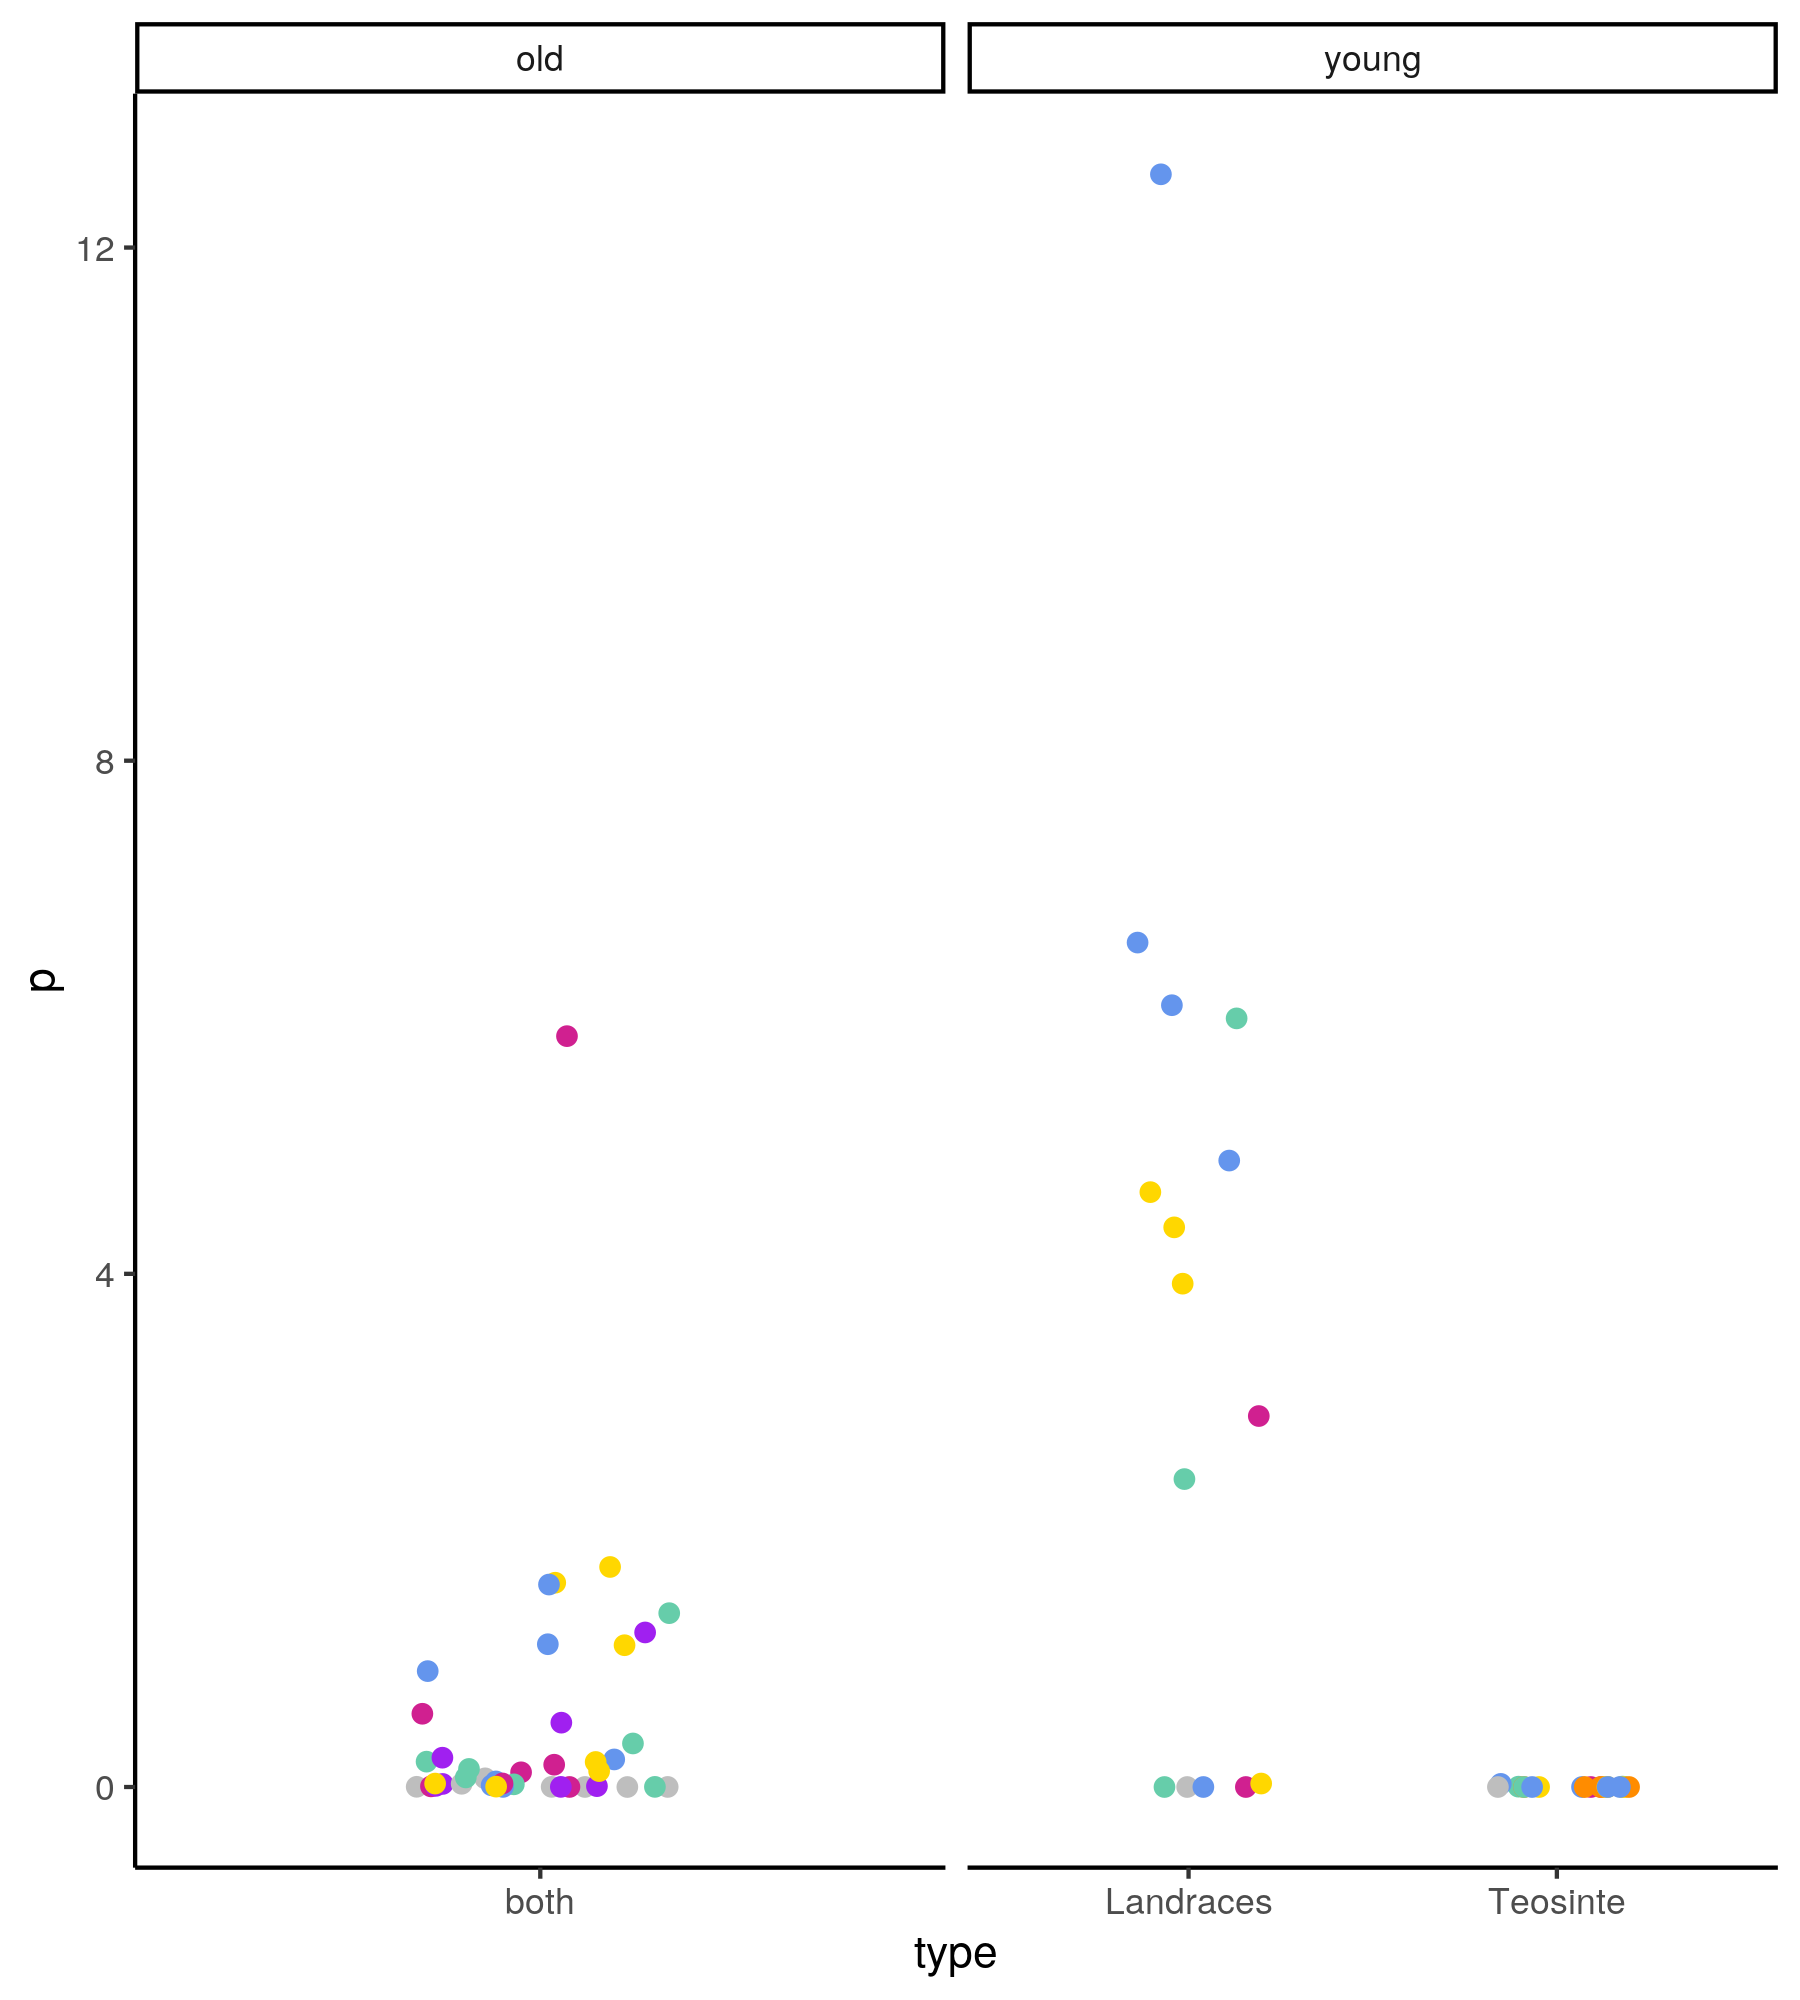

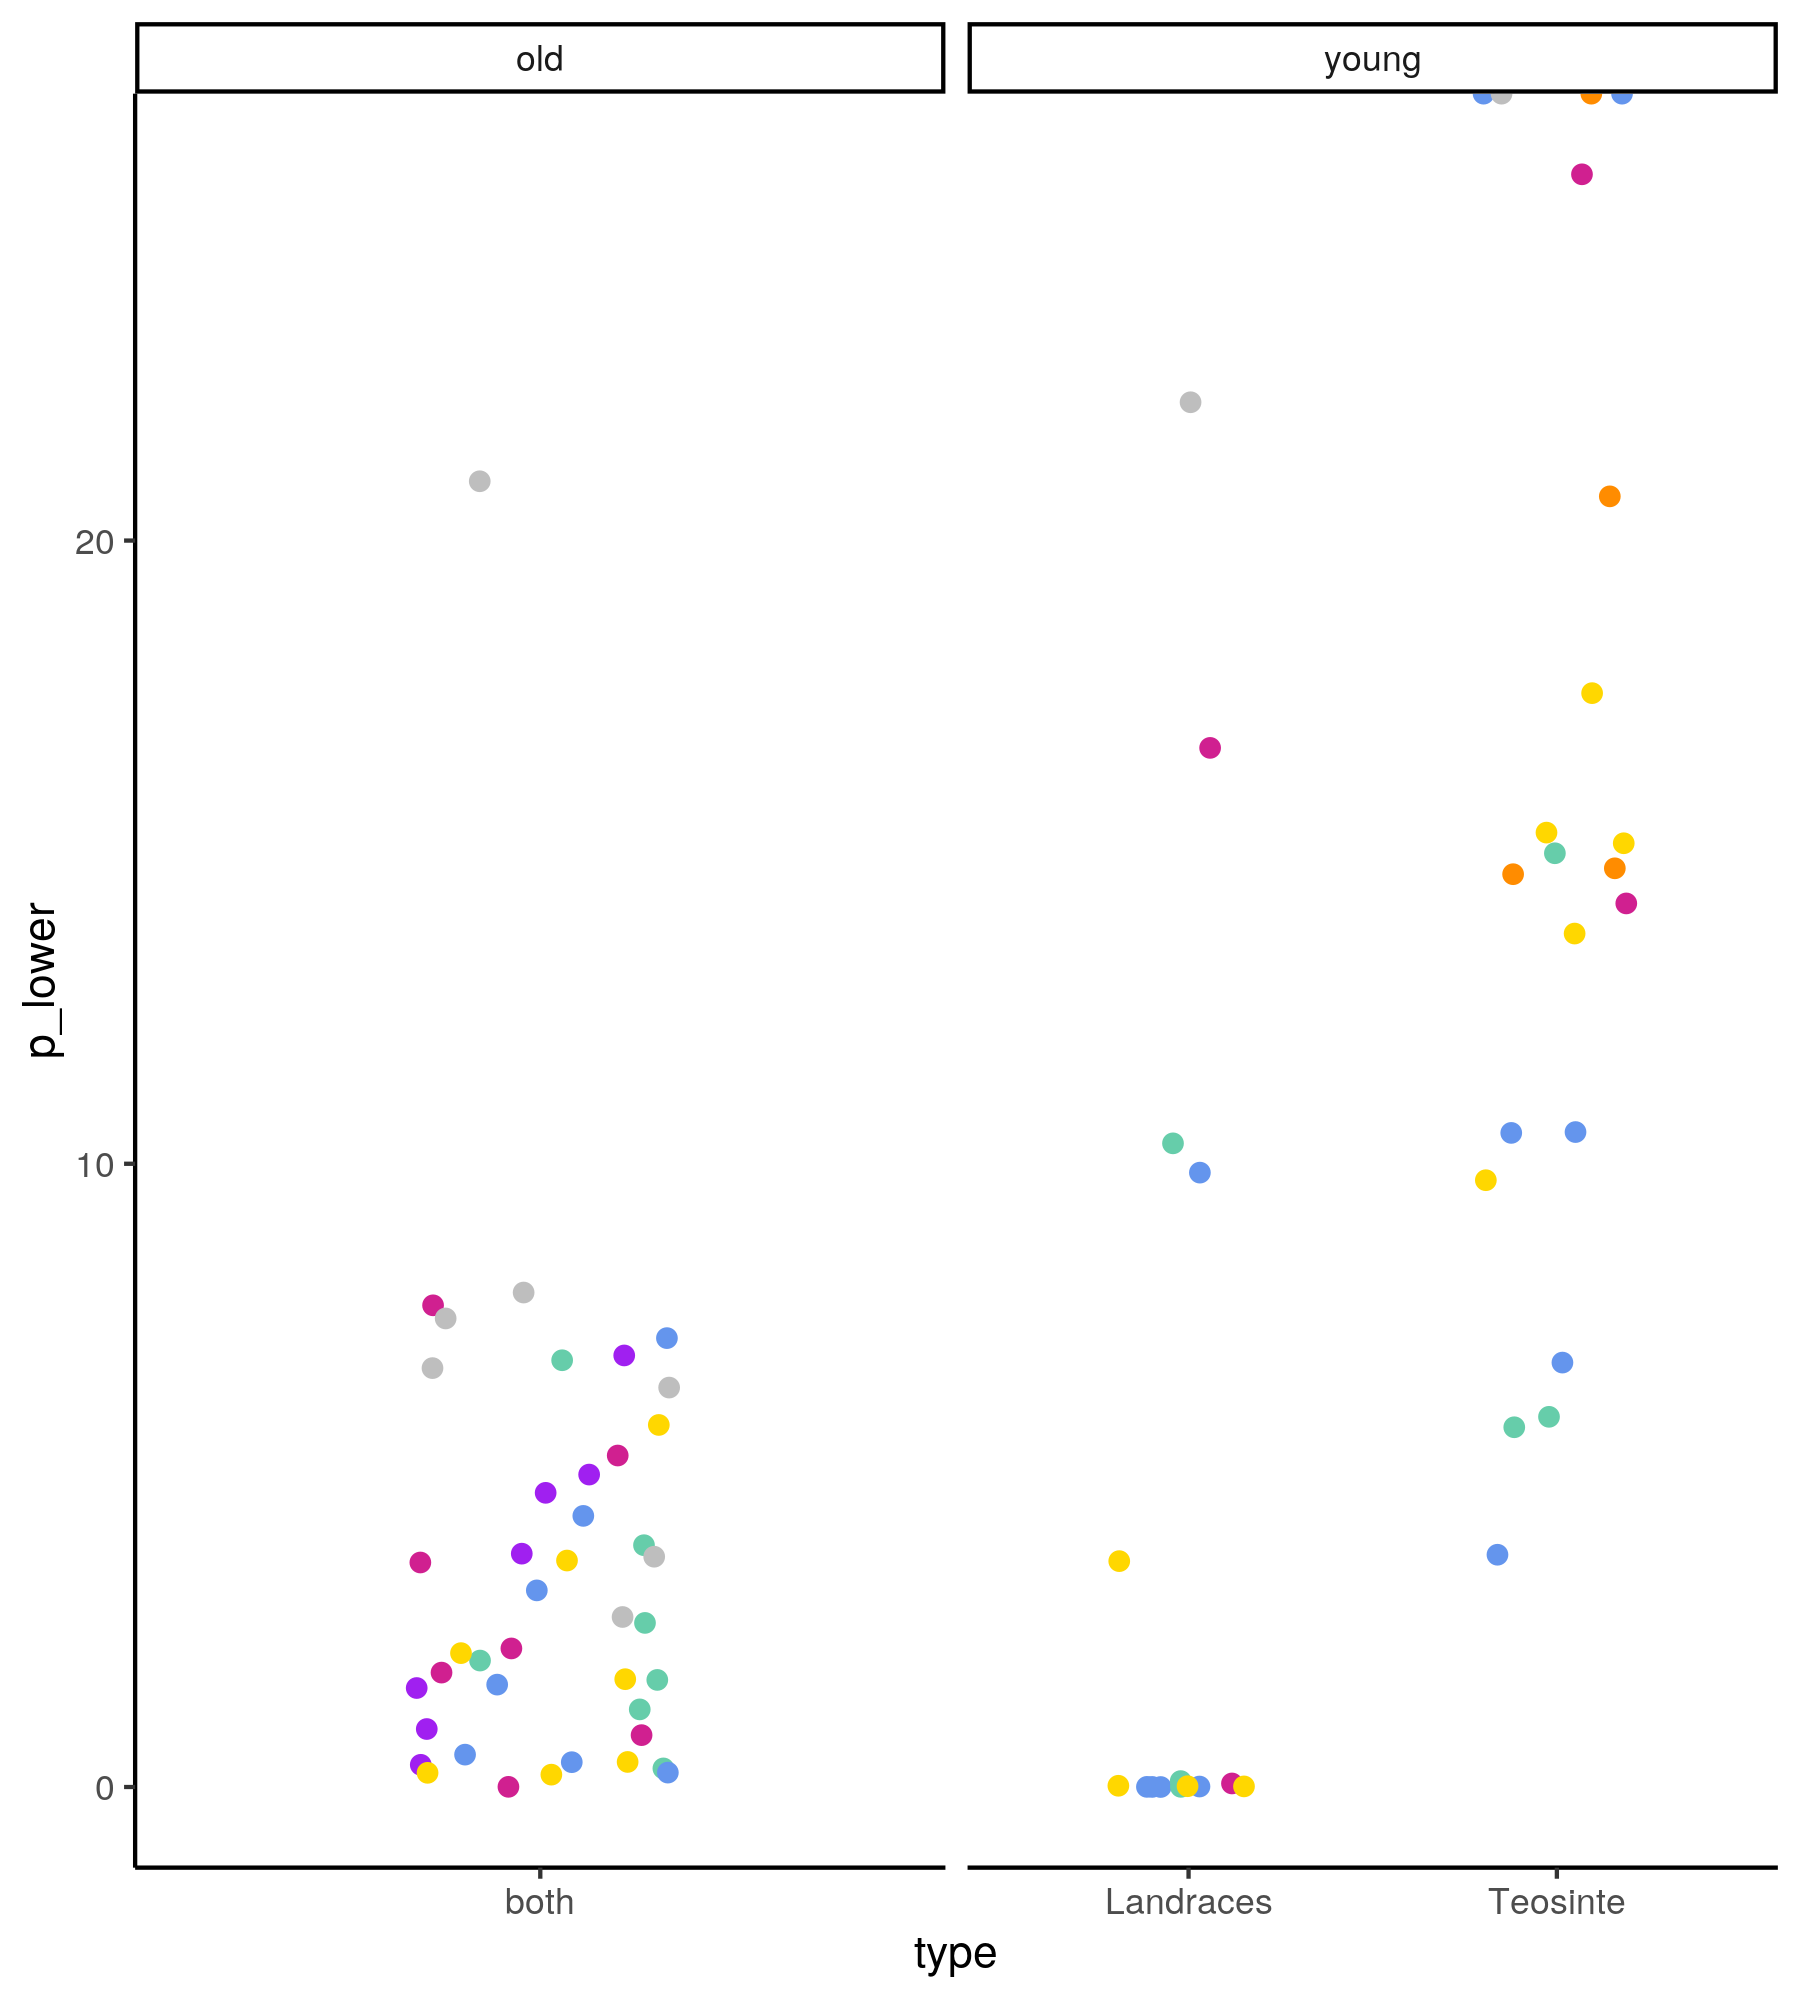

In [26]:

plot_pair_df %>% 
    ggplot(aes(ssp_pop1, ssp_pop2, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(ssp_pop1, ssp_pop2, size = share_count), shape = 1, inherit.aes = F) +
    geom_point(aes(ssp_pop1, ssp_pop2, size = share_count), shape = 1, inherit.aes = F) +
    facet_wrap(~age+type, scales = "free") +
    scale_colour_gradient(low = "white", high = "black") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          strip.text.x = element_text(size = tts_small)) 



p_top5 <- pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    filter(p > 5)
    #group_by(type) %>% 
    #arrange(p_lower) %>% 
    #slice(1:6) %>% 
    #filter(type !="Teosinte")

p_low_top5 <- pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    filter(p_lower > 5)
    #group_by(type) %>% 
    #arrange(desc(p_lower)) %>% 
    #slice(1:6) 


pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    ggplot(aes(type, p)) +
    #geom_jitter(aes(colour = color_pop1, bg = color_pop2), stroke = 2, shape = 21, width = 0.2, height = 0, size = 3) +
    geom_jitter(aes(colour = color_pop1), width = 0.2, height = 0, size = 3) +
    facet_wrap(~age, scales = "free_x") +
    scale_color_identity()


pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    ggplot(aes(type, p_lower)) +
    #geom_jitter(aes(colour = pop1, bg = pop2), stroke = 2, shape = 21, width = 0.2, height = 0, size = 3) +
    geom_jitter(aes(colour = color_pop1), width = 0.2, height = 0, size = 3) +    
    facet_wrap(~age, scales = "free_x") +
    scale_color_identity()


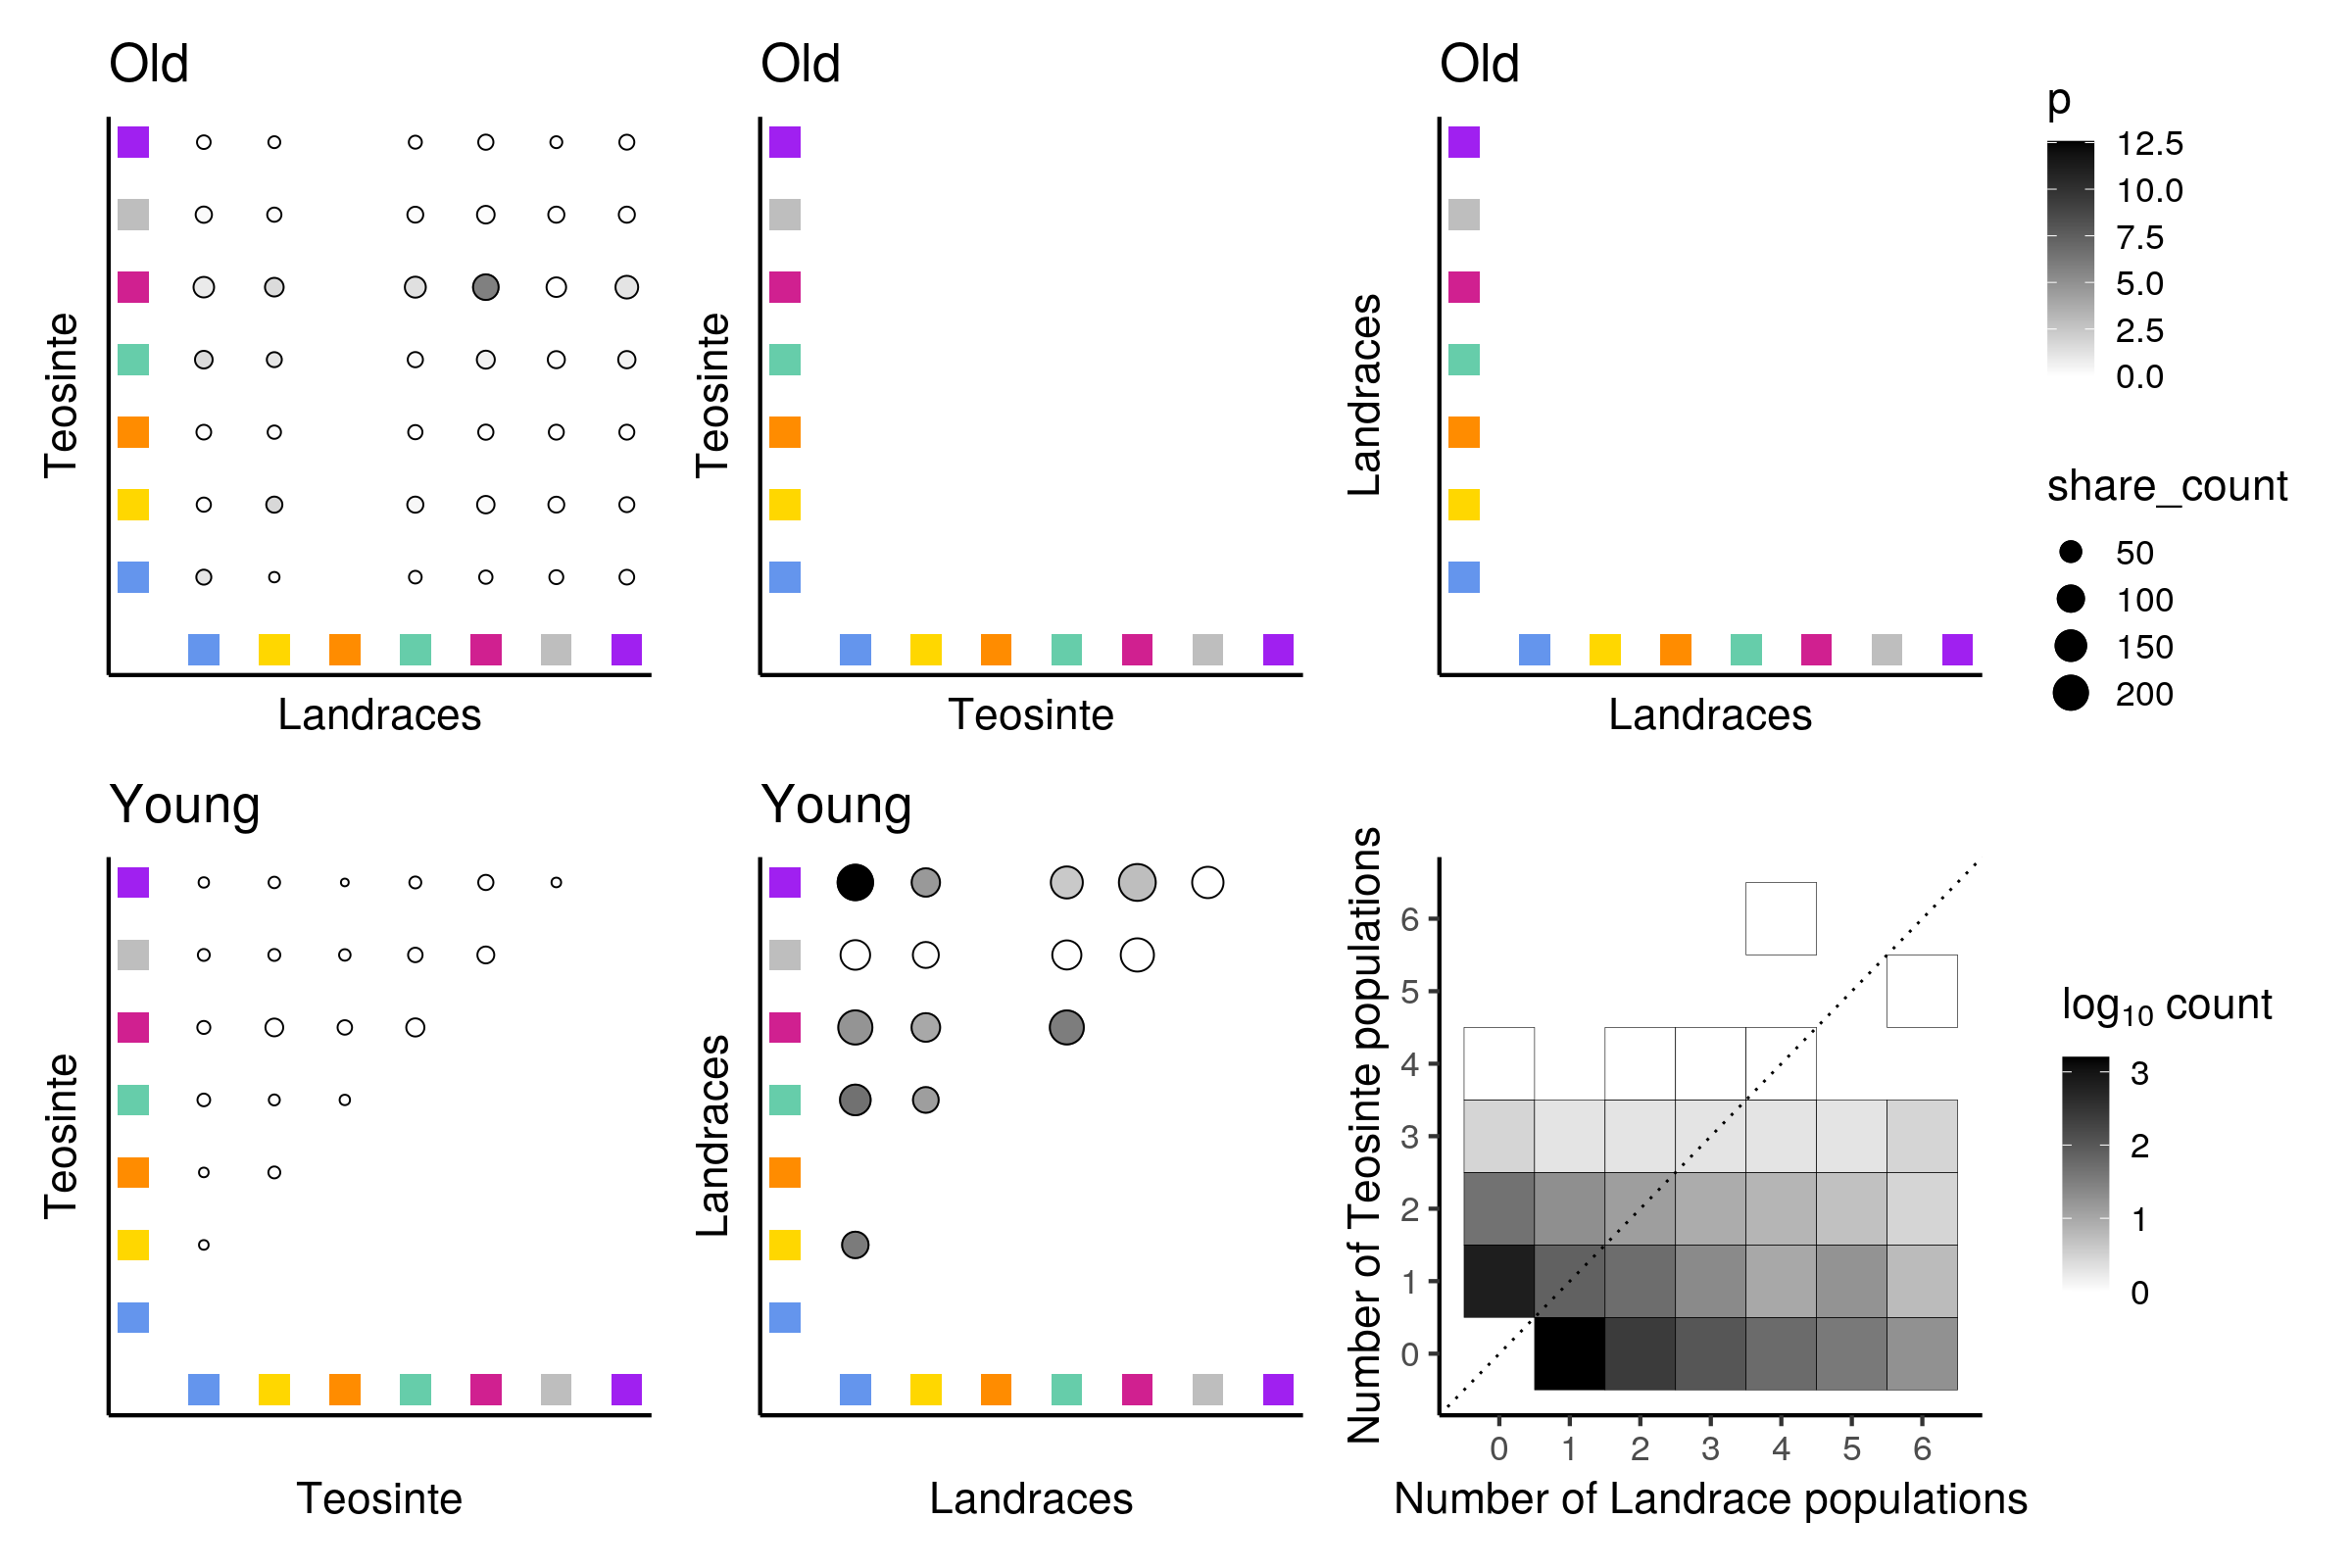

In [27]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 200)

edge_df <- 
    plot_pair_df %>% 
    dplyr::select(color_pop1, color_pop2, pop1_idx, pop2_idx) %>% 
    mutate(zeros = 0)

p_rng <- range(plot_pair_df$p)
size_rng <- range(plot_pair_df$share_count)

old_both <- plot_pair_df %>% 
    filter(age == "old", type == "both") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Landraces") +
    ylab("Teosinte") +
    scale_size(limits = size_rng) 


old_teo <- plot_pair_df %>% 
    filter(age == "old", type == "Teosinte") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Teosinte") +
    ylab("Teosinte") +
    scale_size(limits = size_rng) 

old_lr <- plot_pair_df %>% 
    filter(age == "old", type == "Landraces") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Landraces") +
    ylab("Landraces") +
    scale_size(limits = size_rng) 



young_teo <- plot_pair_df %>% 
    filter(age == "young", type == "Teosinte") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Teosinte") +
    ylab("Teosinte") +
    scale_size(limits = size_rng) 


young_lr <- plot_pair_df %>% 
    filter(age == "young", type == "Landraces") %>% 
    ggplot(aes(pop1_idx, pop2_idx, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(pop1_idx, pop2_idx, size = share_count), shape = 1, inherit.aes = F) +
    scale_colour_gradient(low = "white", high = "black", limits=p_rng) +
    ggnewscale::new_scale_color()+
    geom_point(data = edge_df, aes(pop1_idx, zeros, colour = color_pop1), shape = 15, size = 5, inherit.aes = FALSE) +
    geom_point(data = edge_df, aes(zeros, pop2_idx, colour = color_pop2), shape = 15, size = 5, inherit.aes = FALSE) +
    scale_color_identity() +
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(), 
         axis.ticks.x = element_blank(),
         axis.ticks.y = element_blank()) +
    xlab("Landraces") +
    ylab("Landraces") +
    scale_size(limits = size_rng) 


(old_both +  ggtitle("Old") + theme(legend.position = "n")) +
(old_teo +  ggtitle("Old") + theme(legend.position = "n")) +
(old_lr +  ggtitle("Old")+ theme()) +
(young_teo +  ggtitle("Young") + theme(legend.position = "n")) +
(young_lr +  ggtitle("Young") + theme(legend.position = "n")) +
shareplot +
plot_layout(ncol = 3)


ssp_pop1,ssp_pop2,share_count
<chr>,<chr>,<int>
LR--Amatlan de Canas,LR--Crucero Lagunitas,101
LR--Amatlan de Canas,LR--Los Guajes,150
LR--Amatlan de Canas,LR--Palmar Chico,199
LR--Amatlan de Canas,LR--rangewide,137
LR--Amatlan de Canas,LR--San Lorenzo,219
LR--Amatlan de Canas,Teo--Amatlan de Canas,16
LR--Amatlan de Canas,Teo--Crucero Lagunitas,13
LR--Amatlan de Canas,Teo--El Rodeo,15
LR--Amatlan de Canas,Teo--Los Guajes,29


# A tbl_graph: 13 nodes and 78 edges
#
# A directed acyclic simple graph with 1 component
#
# Node Data: 13 x 4 (active)
  name                  degree ssp   pop              
  <chr>                  <dbl> <chr> <chr>            
1 LR--Amatlan de Canas       0 LR    Amatlan de Canas 
2 LR--Crucero Lagunitas      1 LR    Crucero Lagunitas
3 LR--Los Guajes             2 LR    Los Guajes       
4 LR--Palmar Chico           3 LR    Palmar Chico     
5 LR--rangewide              4 LR    rangewide        
6 LR--San Lorenzo            5 LR    San Lorenzo      
# … with 7 more rows
#
# Edge Data: 78 x 3
   from    to share_count
  <int> <int>       <int>
1     1     2         101
2     1     3         150
3     1     4         199
# … with 75 more rows

Using `sugiyama` as default layout



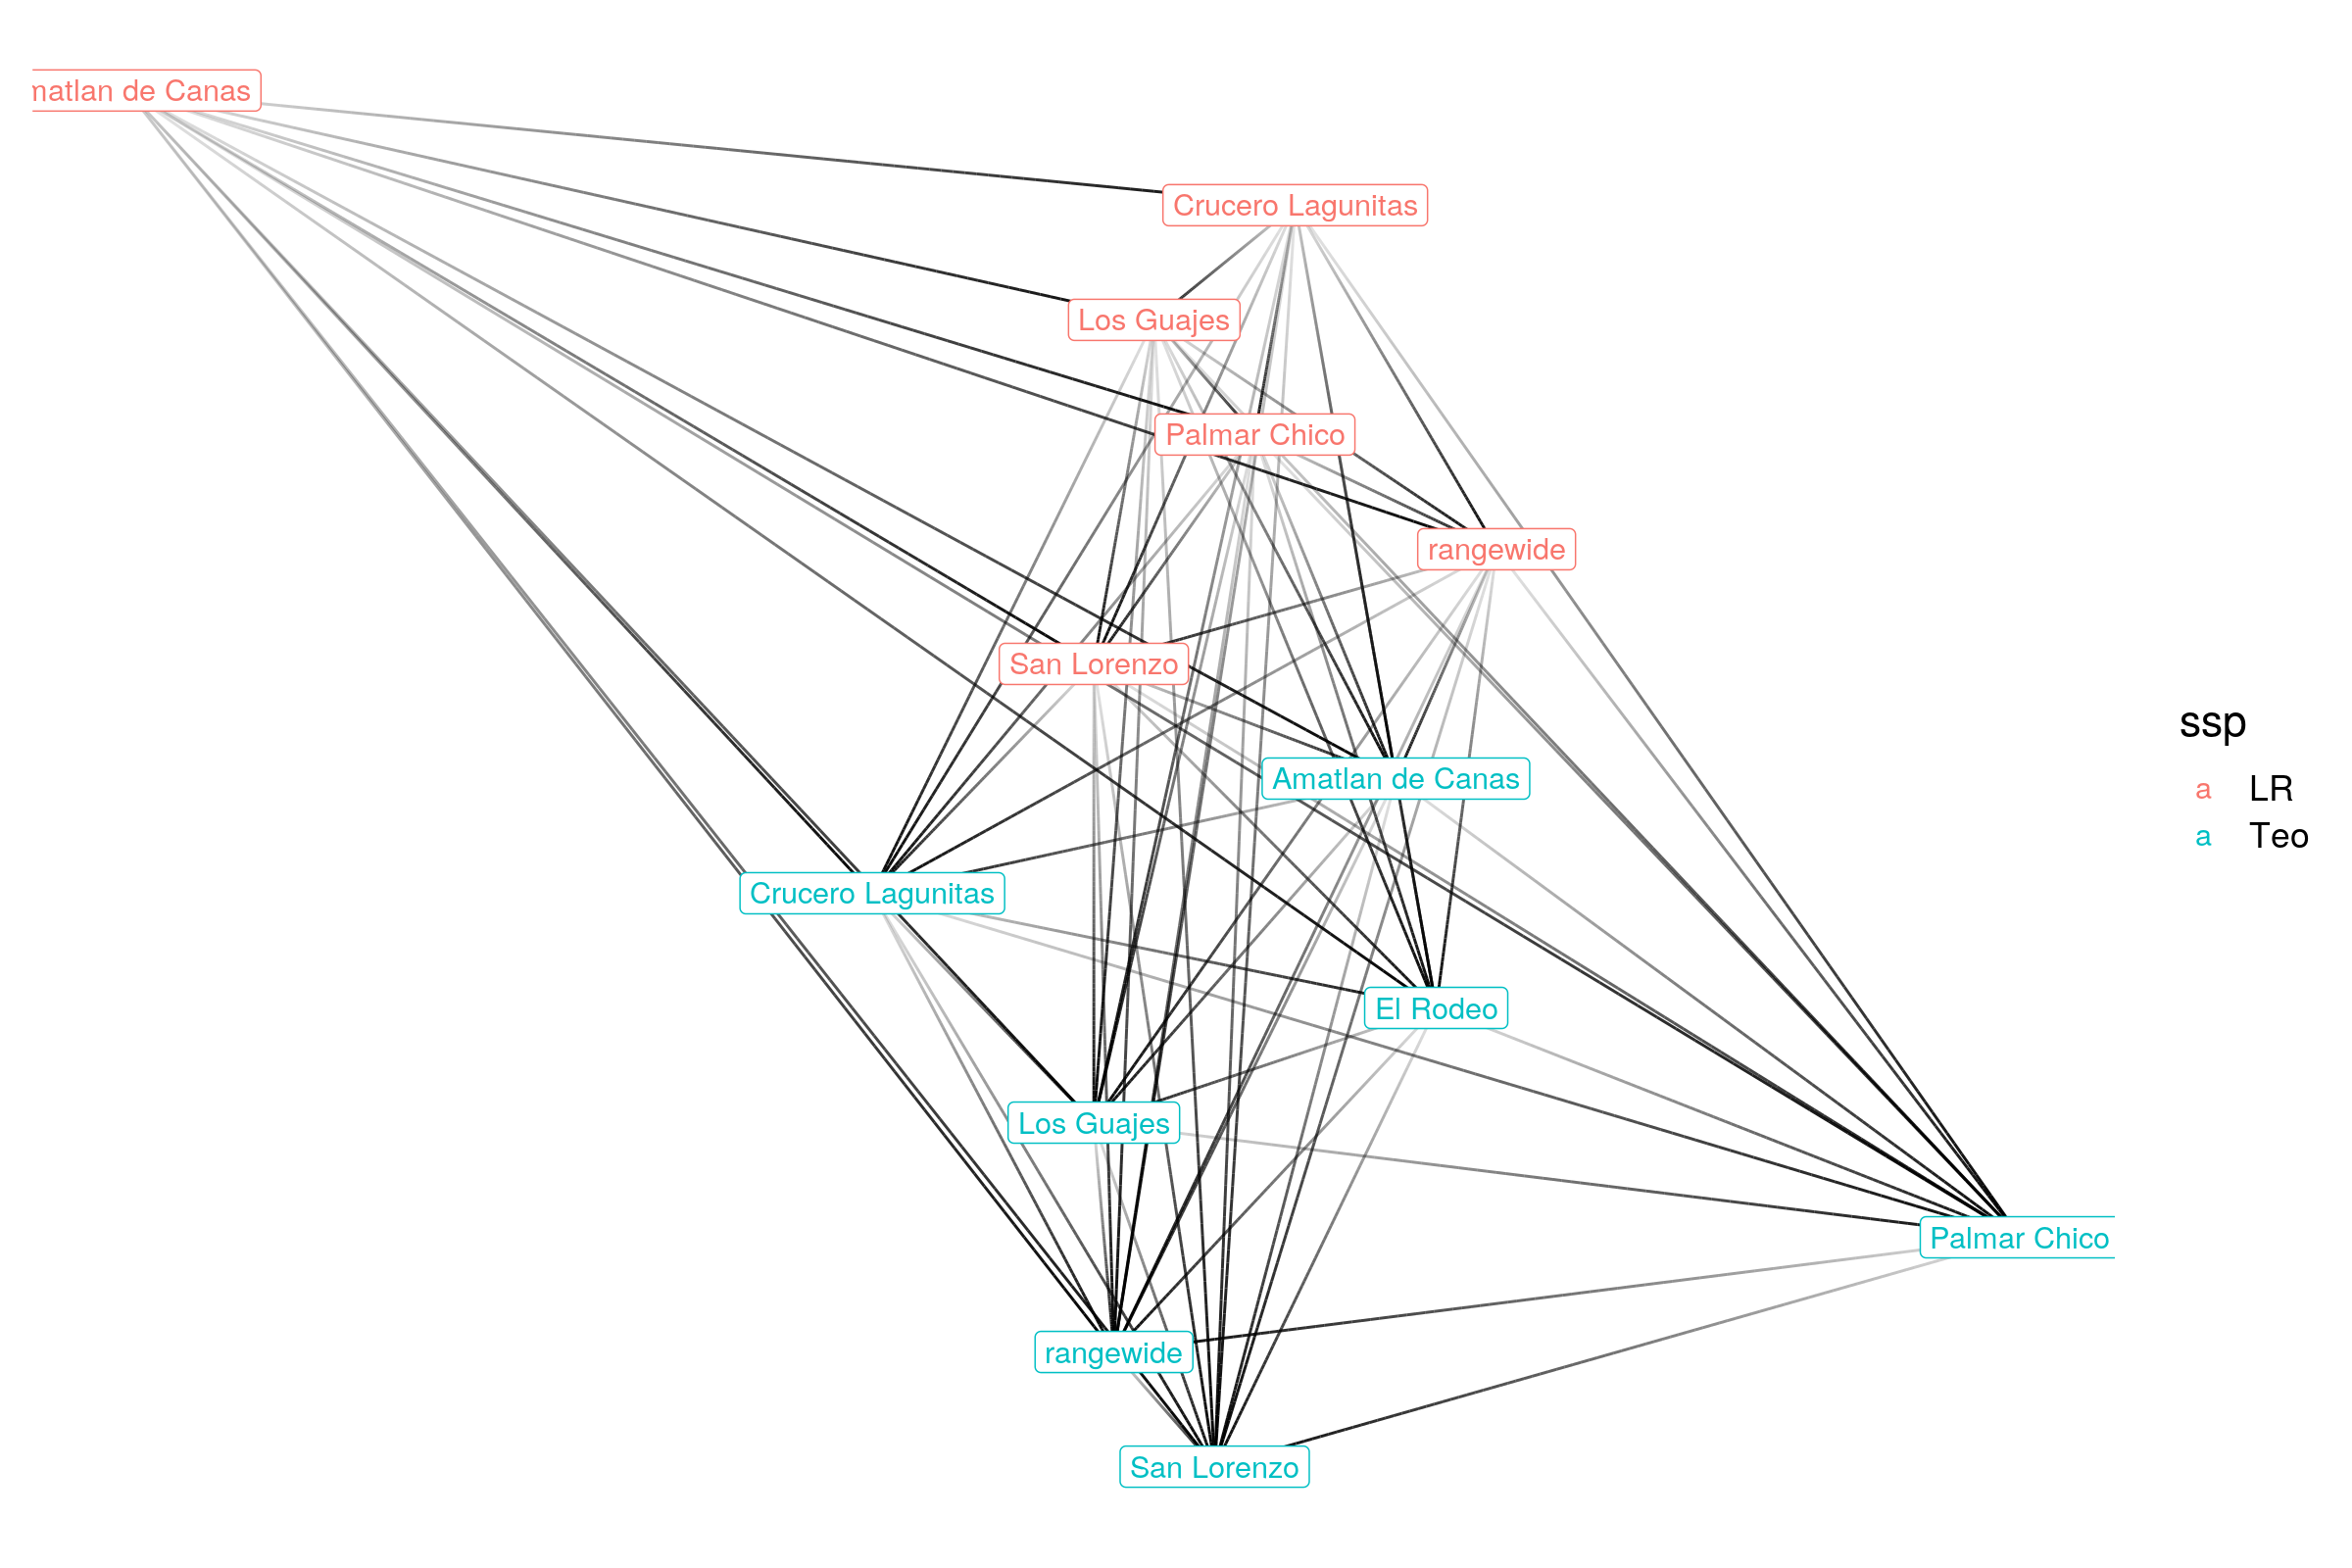

In [30]:
library(tidygraph)

plot_pair_df %>% 
    #filter(age == "young", pair_type == "Landraces") %>%
    mutate(ssp_pop1 = paste0(ssp1, "--", pop1),
          ssp_pop2 = paste0(ssp2, "--", pop2)) %>% 
    dplyr::select(ssp_pop1, ssp_pop2, share_count) %>% 
    arrange(ssp_pop1, ssp_pop2)

network_df <- plot_pair_df %>% 
    #filter(age == "young", pair_type == "Landraces") %>%
    mutate(ssp_pop1 = paste0(ssp1, "--", pop1),
          ssp_pop2 = paste0(ssp2, "--", pop2)) %>% 
    dplyr::select(ssp_pop1, ssp_pop2, share_count)  %>% 
    arrange(ssp_pop1, ssp_pop2) %>% 
    as_tbl_graph() %>%
    mutate(degree = centrality_degree(mode = 'in'),
          ssp = str_split(name, "--", simplify = TRUE)[,1],
          pop = str_split(name, "--", simplify = TRUE)[,2]
          )

network_df
# plot using ggraph
ggraph(network_df) +
    geom_edge_fan(aes(alpha = stat(index)), show.legend = FALSE) +
    #geom_node_point(aes(size = degree, colour = ssp)) +
    geom_node_label(aes(label = pop, colour = ssp))